# 🩺 Anomaly Detection

Bevor die eigentlichen Einflussfaktoren geprüft werden, sollen die Daten des statistischen Datensets hinsichtlich Abweichungen bzw. Anomalien geprüft werden.

Die nachfolgende statistische Analyse bezieht sich daher auf
* Stadt: **Hamburg**
* Kategorie: **Belts and bags**
* Zeitraum: **01.06.2019** und **31.08.2019**

Die Anomaly Detection wird komplett in der SAP Datasphere über die verfügbare SAP HANA PAL Bibliotheken durchgeführt, welche über die Python-Bibliothek im Zugriff sind.

Dabei werden folgende Schritte durchgeführt:
* Seasonal Decomposing (algorithms.pal.tsa.seasonal_decompose) um Trends und saisonale oder zyklische Effekte zu filtern.
* Methode 1: Varianztest (algorithms.pal.preprocessing.variance_test) durch Median und Standardabweichung
* Methode 2: Inter-Quartile Range (IQR) (algorithms.pal.stats.iqr) durch die Abweichung zwischen den Quartilen
* Viualisierung der Anomalien
* Prüfung je Artikel innerhalb der Kategorie

## 🔗 Verbindung zu statistischen Datenset

In [4]:
from json import load
dsp_buaap = load(open('../.env'))

import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(
    address=dsp_buaap['host'], 
    port=dsp_buaap['port'], 
    user=dsp_buaap['user'], 
    password=dsp_buaap['password'],
    encrypt = True, # must be set to True when connecting to HANA Cloud or SAP Datasphere
    sslValidateCertificate = True
    )

hdf = conn.table('VIEW_ZPCS_CP_02', schema=dsp_buaap['schema']).filter('"ZPCSSTADT" = \'Hamburg\' \
                                                                        AND "0CALDAY" > \'20190601\' AND "0CALDAY" < \'20190831\'')
#--AND "ZEFART__ZEFCAT___T" = \'Belts and bags\' \
#hdf.describe().collect()

Aus dem statistischen Datenset laden wir einmal (vorab) die Anzahl Artikel als Python-Liste. Generell ist die detaillierste Ebene und deren Ausprägungen eine gute Indikation, wie detailliert die Daten noch vorliegen.

In [5]:
zefarts = hdf.distinct(['ZEFART', 'ZEFART___T']).collect()
print(len(zefarts.values.tolist()), zefarts.values.tolist())

49 [['0000140515', '9cm Gold Brooch'], ['0000162840', 'Aladdin Silk Trousers'], ['0000169253', 'Alaska Satin Belt'], ['0000138627', 'Belt Buckle'], ['0000163490', 'Bengal Striped Medium Trousers'], ['0000163907', 'Burlington Jacket'], ['0000172438', 'Cable Stitch Knitted Jacket'], ['0000169571', 'Canvas Shorts'], ['0000166136', 'Chenille Leotard T-Shirt'], ['0000182488', 'Chenille Leotard T-Shirt'], ['0000173941', 'Clown Printed Satin Trousers'], ['0000178903', 'Cowl Neck Tunic'], ['0000181252', 'Crepe Trousers'], ['0000146552', 'Crocodile Wallet'], ['0000182343', 'Fabric Sampler'], ['0000169011', 'Fake Fur Overcoat'], ['0000187901', 'Fake Leopard Skin Gloves with Lurex Trim'], ['0000157599', 'Flower Stem Patterned Silk Scarf'], ['0000184215', 'Goat Wool Skirt'], ['0000151810', 'Goldset Pearl Necklace'], ['0000184264', 'Grenelle Printed Jeans'], ['0000145403', 'Grooved Nickel Bracelet'], ['0000169272', 'Hair Clip'], ['0000144940', 'Herringbone Cardigan'], ['0000143269', 'Jacquard Scarf

## 🌊 Seasonal Decomposing

Wie bereits eingangs erwähnt wird bei einem Seasonal Composing normalisiert hinsichtlich Trends, sowie saisonaler und zyklischer Effekte. Dabei wird die Kennzahl ebenfalls normalisiert, d.h. die absoluten Werte der Kennzahl entsprechend nicht, in unserem Fall, dem eigentlichen Umsatz.

Es gibt zwei Zeilen (4 + 5), wobei eine der beiden Zeilen auskommentiert sein muss, um entweder die gesamten Artikel zu analysieren. Oder wahlweise einen Artikel.

In [6]:
df_anomalies_iqr = []
from hana_ml.algorithms.pal.tsa.seasonal_decompose import seasonal_decompose

#hdf_dfashion = hdf.filter('"ZEFART___T" = \'Alaska Satin Belt\'')
hdf_dfashion = hdf

# seasonal_decompose function is to decompose a time series into three components: trend, seasonality and random noise.
# Once you remove the trend, seasonal and cyclical effects you can check for anomalies
hdf_dfashion = hdf_dfashion.add_id(id_col='ID', ref_col='0CALDAY')
stat, decomposed = seasonal_decompose(data = hdf_dfashion,
                                        key = 'ID',
                                        endog = 'ZEFNS',
                                        extrapolation=True)

## 🎚️ Methode 1: Varianztest

Eine einfache Methode ist ein Varianztest auf die Daten durchzuführen. Je nach Datenprofil lohnt sich der Blick auf mehrere Methoden, da die vermeintliche genauere Methoden nicht unbedingt zu besseren Ergebnis führt.

In [7]:
# Methode 1
# Variance Test is a method to identify the outliers of n number of numeric data {xi} where 0 < i < n+1, 
# using the mean and the standard deviation of n number of numeric data.
df_anomalies_iqr = []
from hana_ml.algorithms.pal.preprocessing import variance_test

test_res, _ = variance_test(data=decomposed,
                                key='ID',
                                data_col='RANDOM', # SEASONAL, TREND, RANDOM (white noise)
                                sigma_num=3)

anomalies_iqr_id = conn.sql('SELECT ID FROM ({}) WHERE IS_OUT_OF_RANGE = 1'.format(test_res.select_statement))
anomalies_iqr = conn.sql('SELECT * FROM ({}) WHERE ID IN ({})'.format(hdf_dfashion.select_statement,
                                                                    anomalies_iqr_id.select_statement))

print(anomalies_iqr.count())

75


## 🎚️ Methode 2: Inter-Quartile Range (IQR)

Im Gegensatz zum Varianztest prüft man bei einem IQR die Abweichung zwischen den Quartilen. Je nach Datenprofil führt diese Methode zu einem unterschiedlichen Ergebnis. In diesem Fall werden für alle Artikel deutlich mehr Anomalien gefunden.

In [8]:
# Methode 2
# Perform the inter-quartile range (IQR) test to find the outliers of the data. 
# The inter-quartile range (IQR) is the difference between the third quartile (Q3) and the first quartile (Q1) of the data.
from hana_ml.algorithms.pal.stats import iqr
test_res, _ = iqr(data=decomposed, 
                    key='ID', 
                    col='RANDOM')  # SEASONAL, TREND, RANDOM (white noise)


anomalies_iqr_id = conn.sql('SELECT ID FROM ({}) WHERE IS_OUT_OF_RANGE = 1'.format(test_res.select_statement))
anomalies_iqr = conn.sql('SELECT * FROM ({}) WHERE ID IN ({})'.format(hdf_dfashion.select_statement,
                                                                    anomalies_iqr_id.select_statement))

print(anomalies_iqr.count())

437


## 📊 Visualisierung

Die Visualisierung wird lokal mit der Python-Bibliothek matplotlib durchgeführt. Diese Bibliothek erlaubt umfangreiche Modifikationen, so dass wir nachfolgend nicht nur den Verlauf über den Zeitraum anzeigen können, sondern auch die gefundenen Anomalien mit ausgeben könne.

Calendar days [Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-06 00:00:00'),

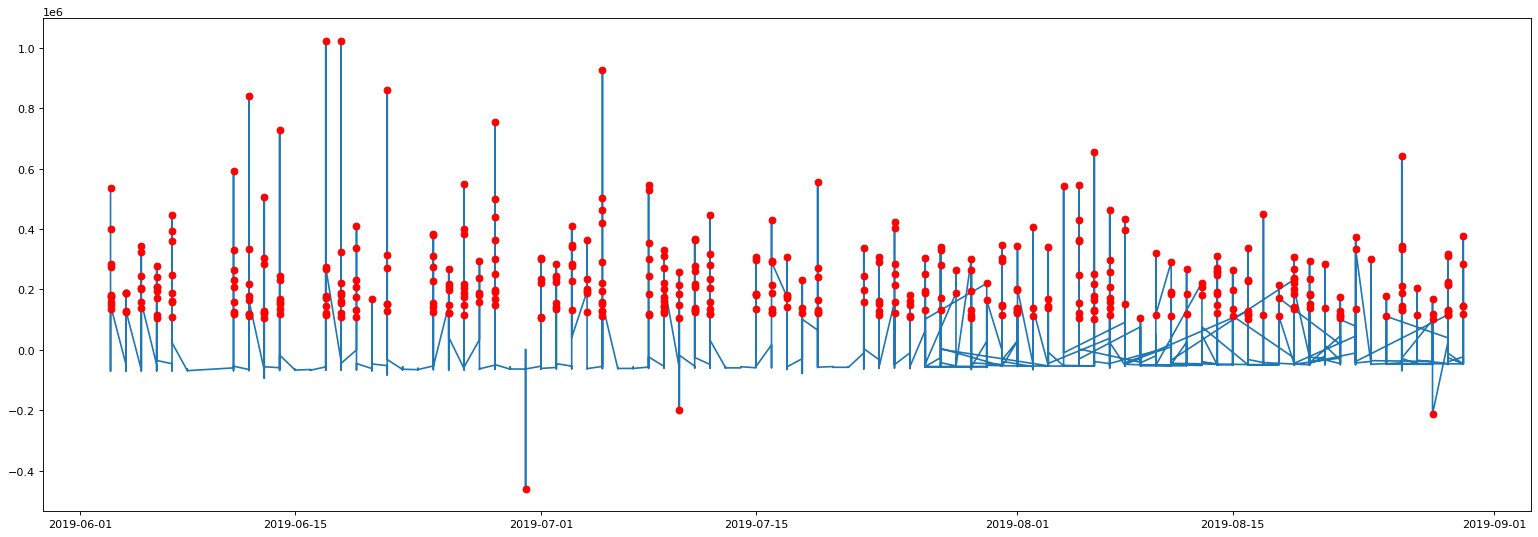

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure

df_dfashion = hdf_dfashion.collect()
figure(figsize = (24, 8), dpi = 80)
dc = decomposed.collect()
# Base line 
plt.plot(pd.to_datetime(df_dfashion['0CALDAY']), dc['RANDOM'])
# Anomaly marker
oidx = np.array(anomalies_iqr.collect()['ID']) - 1
plt.plot(pd.to_datetime(df_dfashion['0CALDAY'])[oidx], dc.iloc[oidx, 3], 'ro')
print('Calendar days', pd.to_datetime(df_dfashion['0CALDAY'])[oidx].to_list())
plt.show()

Im Ergebnis sieht man generell sehr viele maximale Werte. Beinahe jede Spitze wird durch IQR als Anomalie erkannt. Der Varianztest ist weniger sensibel und wird noch die acht höchte Maximumwerte als Anomalie erkennen. Durch das generelle Datenprofil und die bislang bekannten Schwankungen tendieren wir zum Varianztest.

## 🧼 Anomaly Detection für alle Artikel

Die Menge an Artikel ist aktuell sehr überschaubar. Je mehr Artikel oder je höher die Detailstufe umso umfangreicher die nachfolgenden Liste an Anomalien. Wir nutzen die bislang beschriebenen Schritte und führen einen Varianztest je Artikel durch und lassen diesen visualisieren.

**Die bisherigen Anomalien sind lediglich eine Indikation! Das heißt nach dem man Informationen über Anomalien erhalten hat, müssen diese Anomalien (manuell) geprüft werden. Erst nach der Überprüfung kann entschieden werden, ob die Anomalien eine Unschärfe sind, welche man berücksichtigen sollte oder zum Beispiel Betrugsfälle. Oder Datenfehler.**

0000140515 9cm Gold Brooch
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


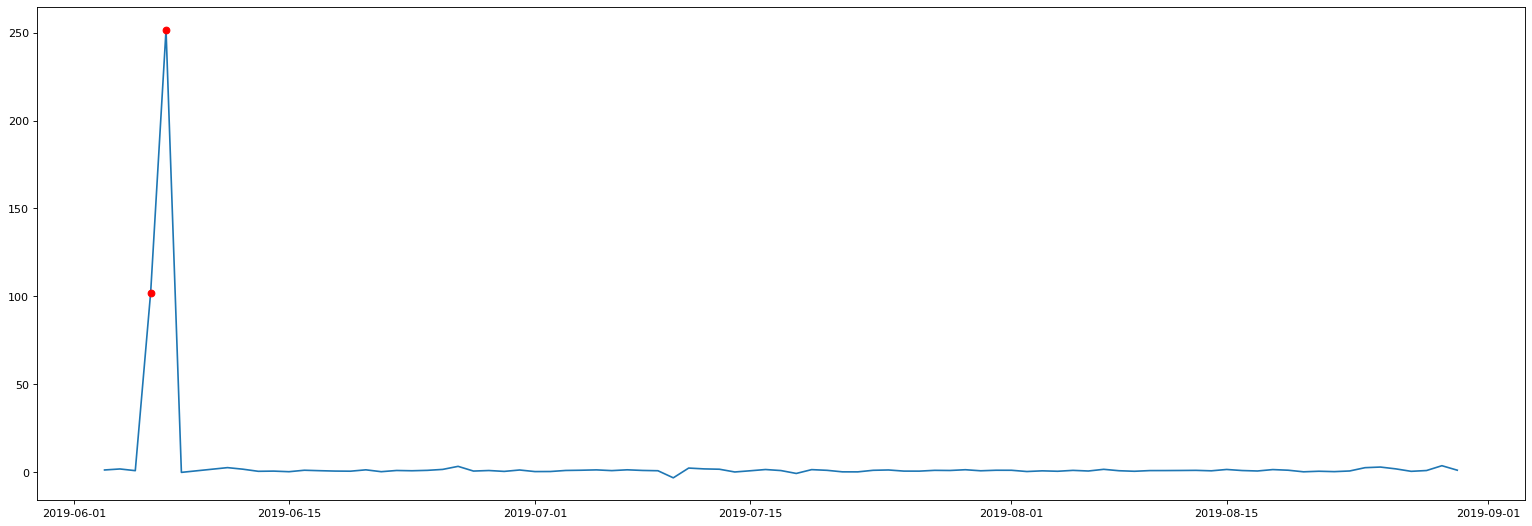

0000162840 Aladdin Silk Trousers
No anomalies found for Aladdin Silk Trousers
0000169253 Alaska Satin Belt
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


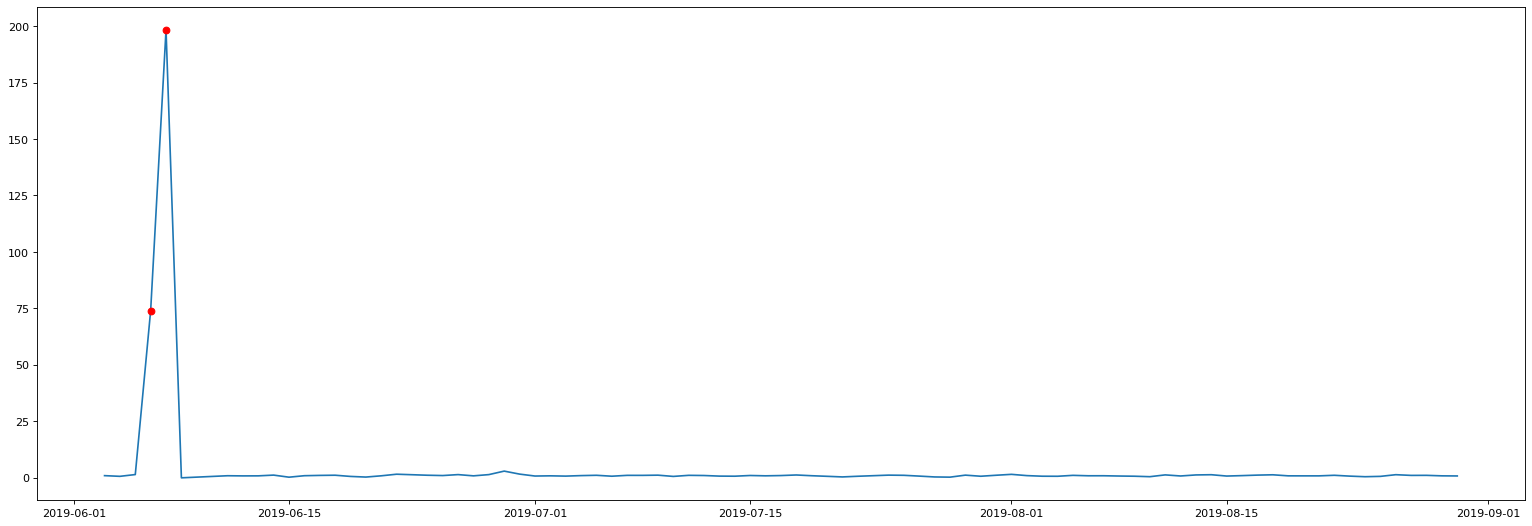

0000138627 Belt Buckle
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


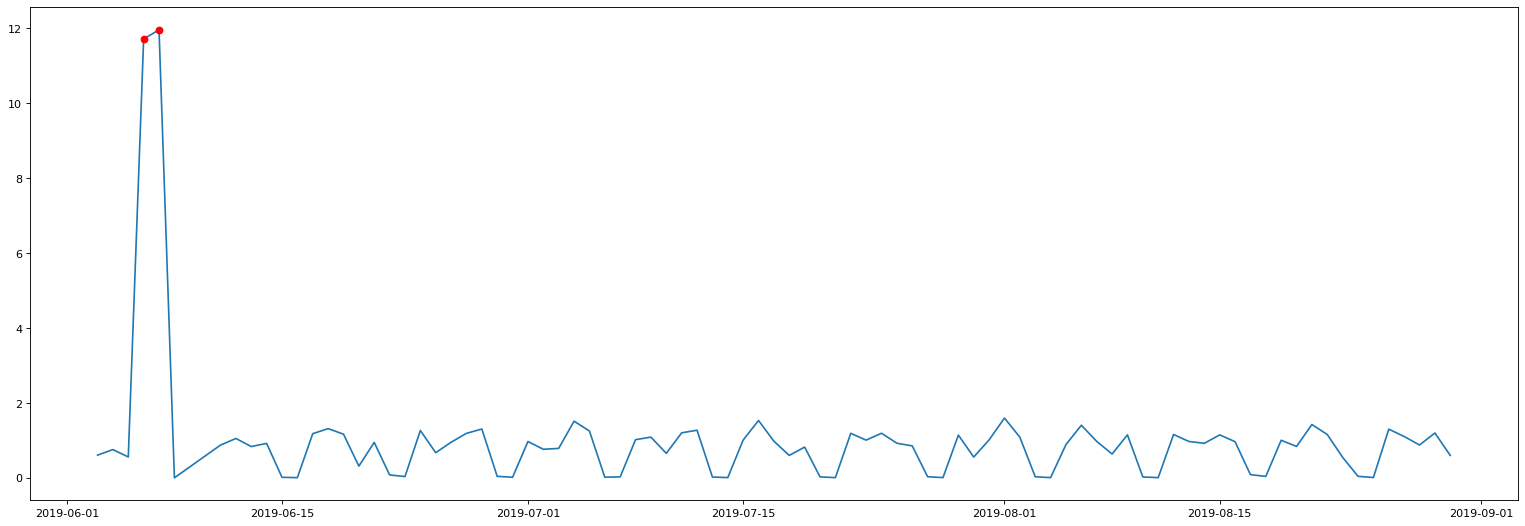

0000163490 Bengal Striped Medium Trousers
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-08-27 00:00:00')]


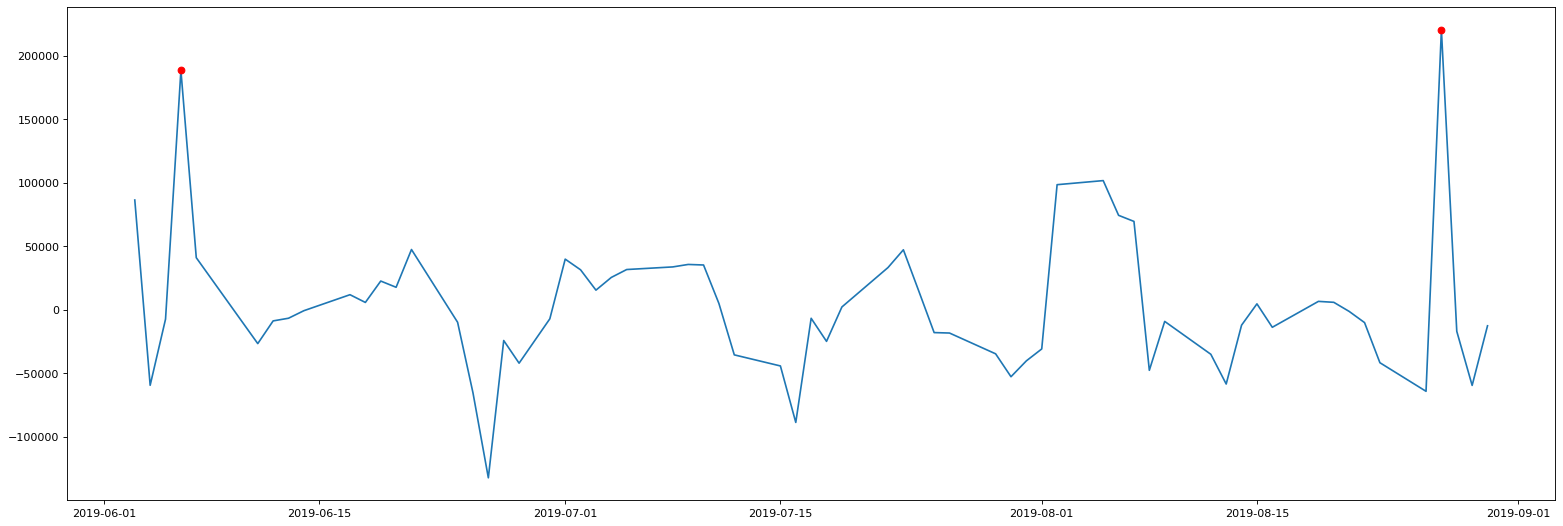

0000163907 Burlington Jacket
Calendar days [Timestamp('2019-06-07 00:00:00')]


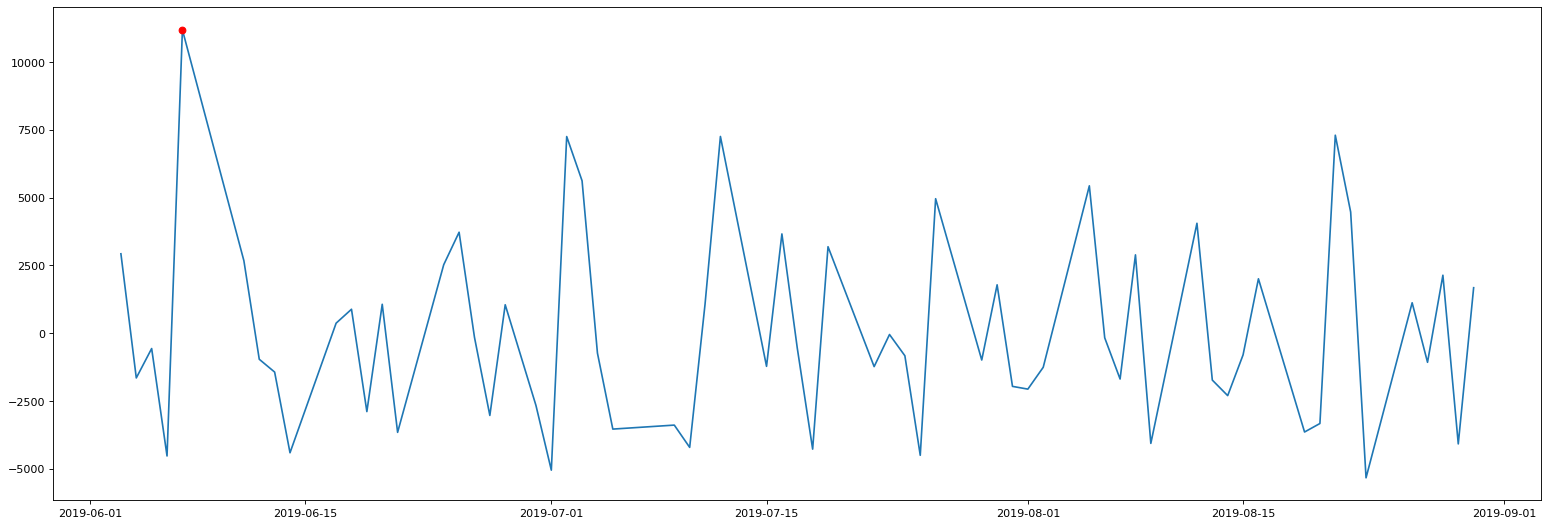

0000172438 Cable Stitch Knitted Jacket
No anomalies found for Cable Stitch Knitted Jacket
0000169571 Canvas Shorts
Calendar days [Timestamp('2019-08-23 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2019-08-29 00:00:00')]


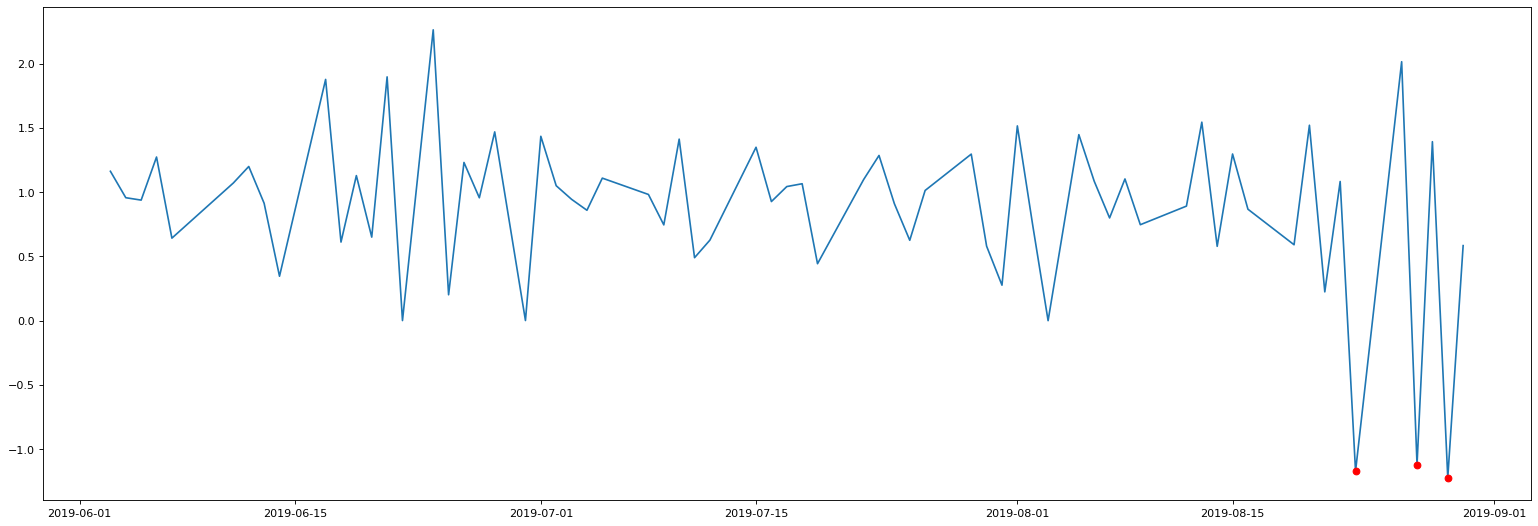

0000166136 Chenille Leotard T-Shirt
Calendar days [Timestamp('2019-07-01 00:00:00'), Timestamp('2019-08-26 00:00:00')]


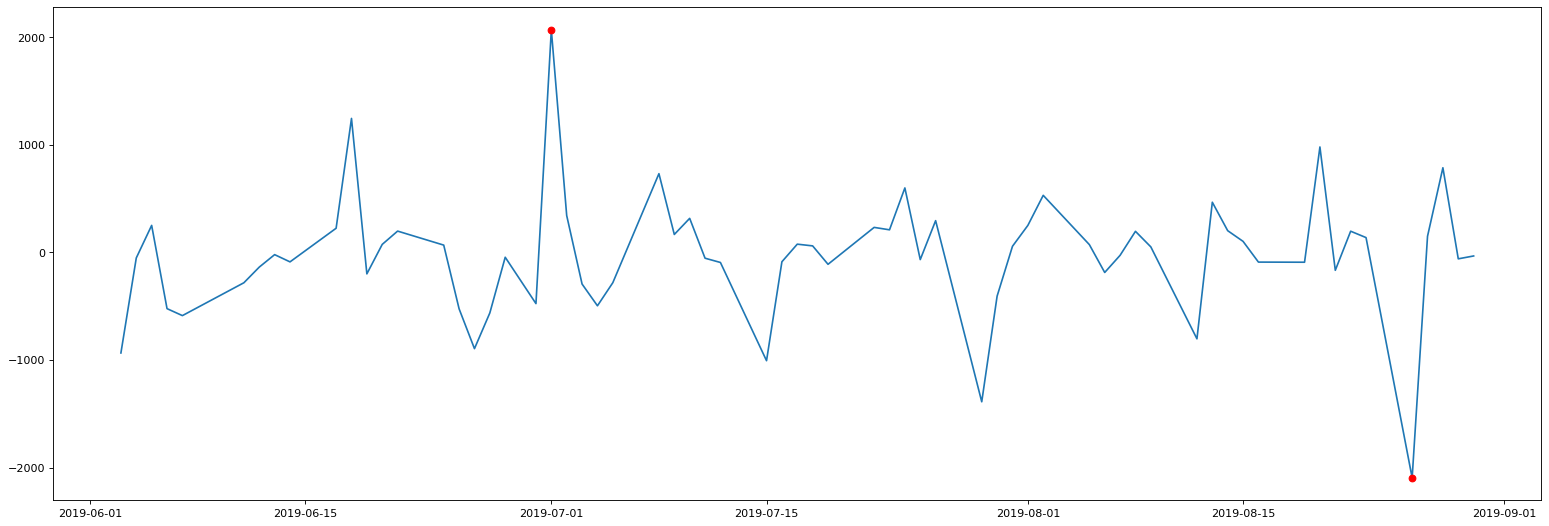

0000182488 Chenille Leotard T-Shirt
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


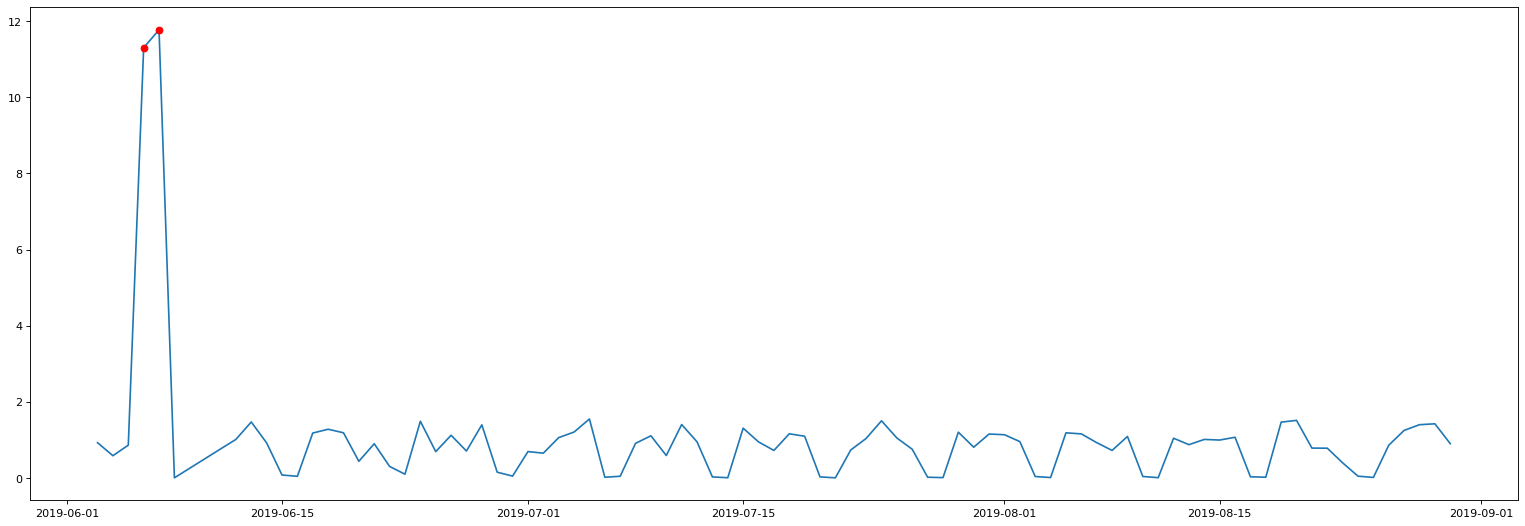

0000173941 Clown Printed Satin Trousers
Calendar days [Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-06 00:00:00')]


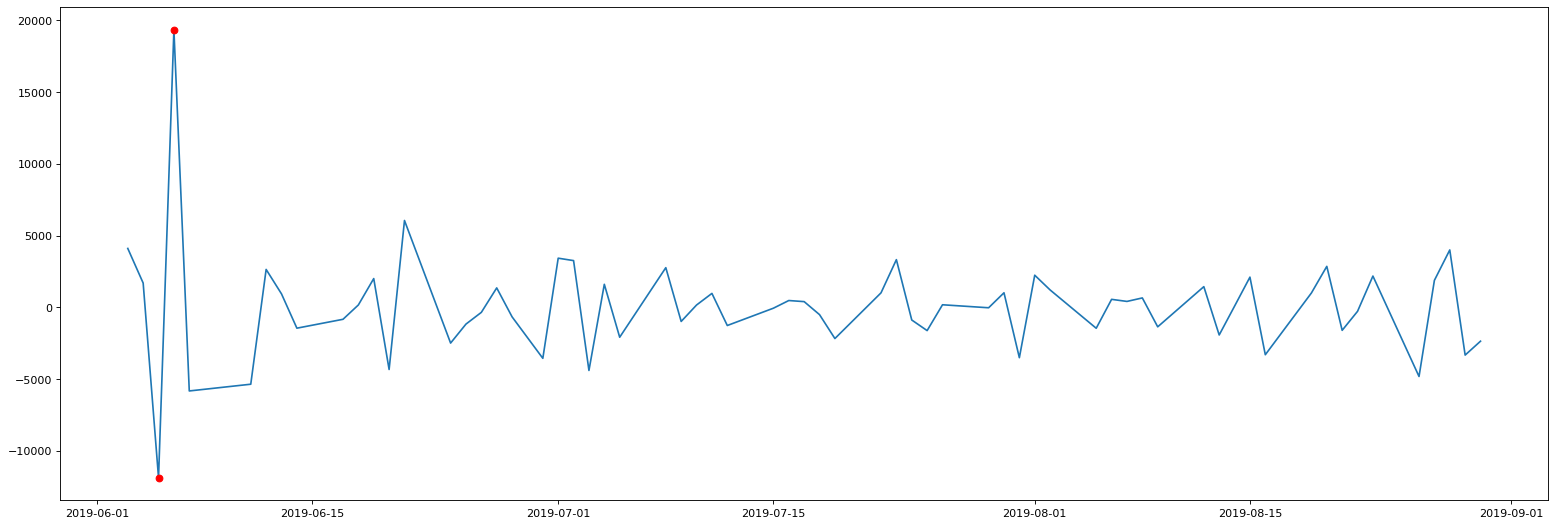

0000178903 Cowl Neck Tunic
Calendar days [Timestamp('2019-06-05 00:00:00'), Timestamp('2019-06-13 00:00:00')]


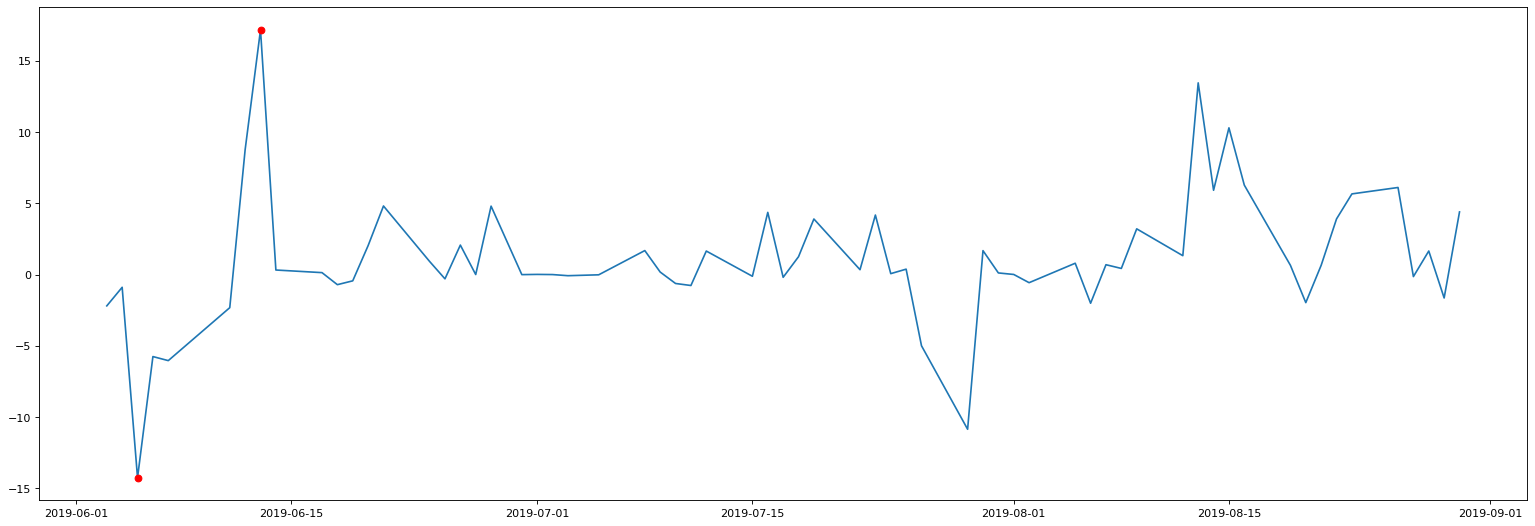

0000181252 Crepe Trousers
Calendar days [Timestamp('2019-08-28 00:00:00')]


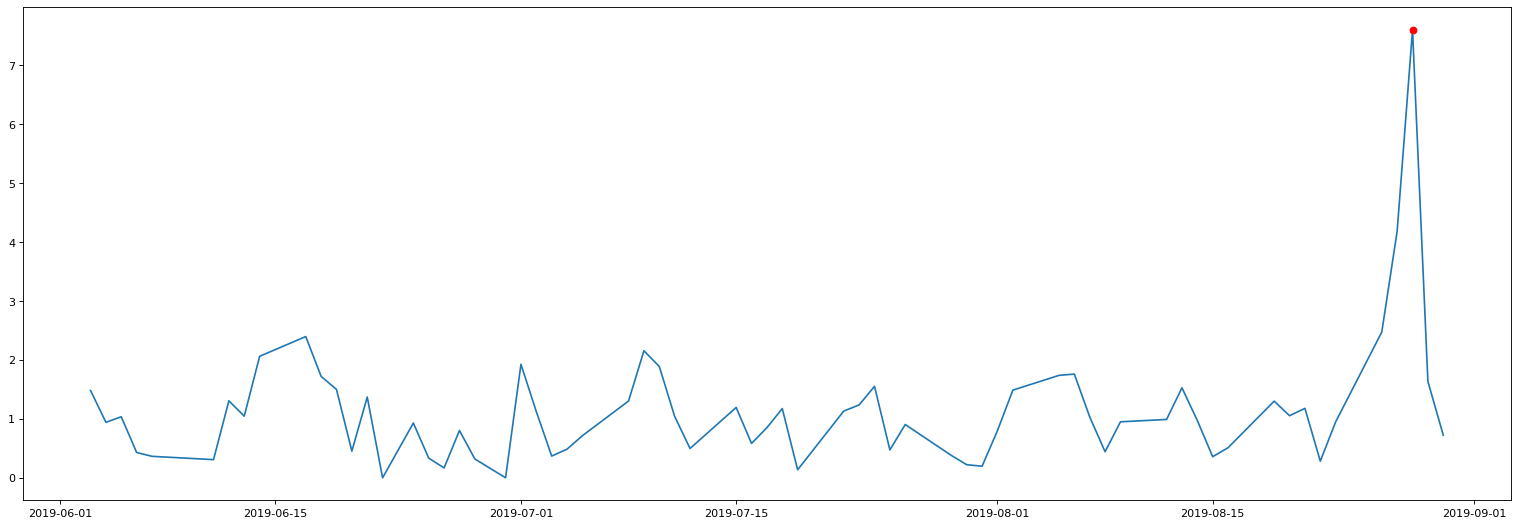

0000146552 Crocodile Wallet
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


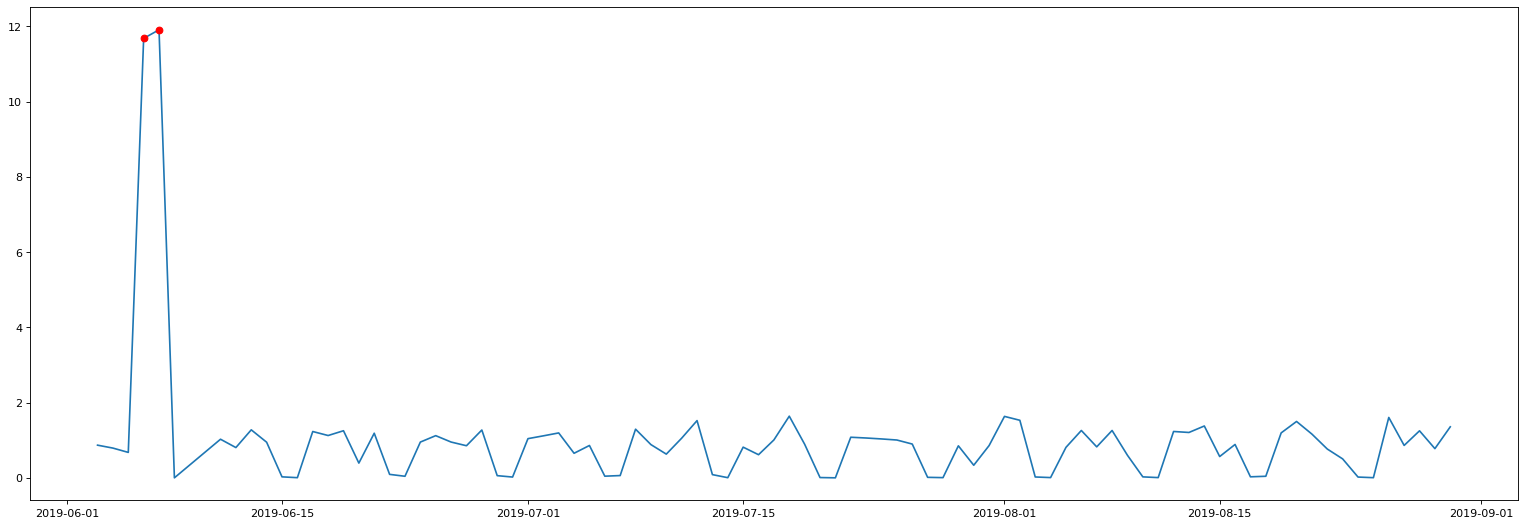

0000182343 Fabric Sampler
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


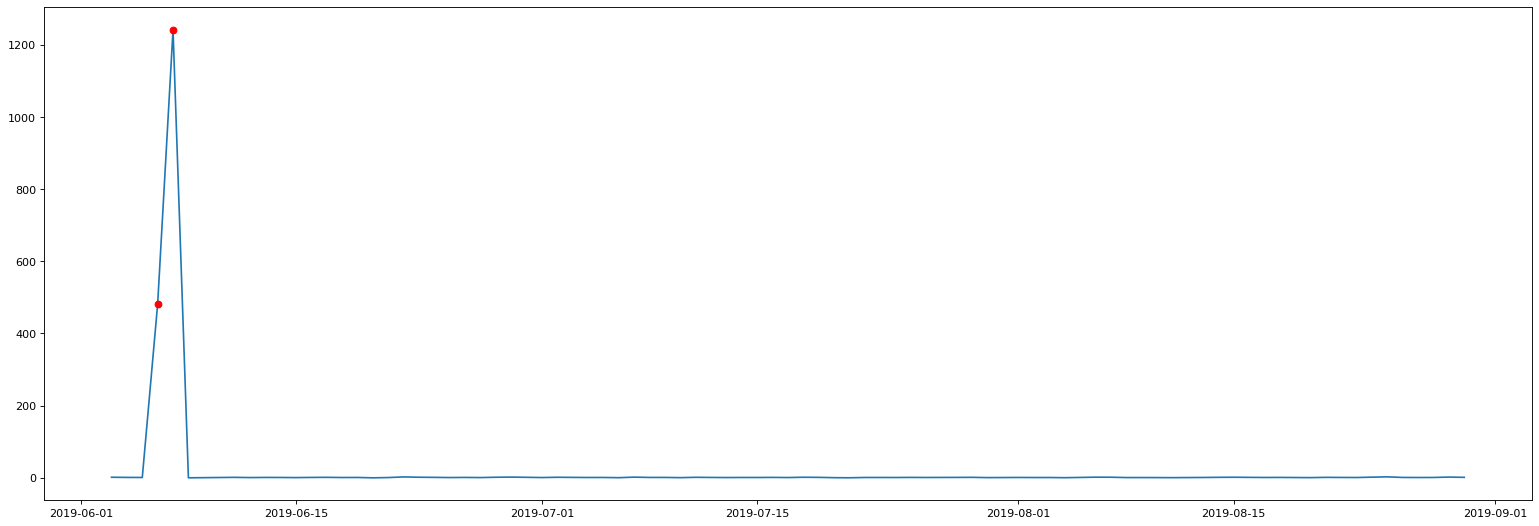

0000169011 Fake Fur Overcoat
No anomalies found for Fake Fur Overcoat
0000187901 Fake Leopard Skin Gloves with Lurex Trim
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


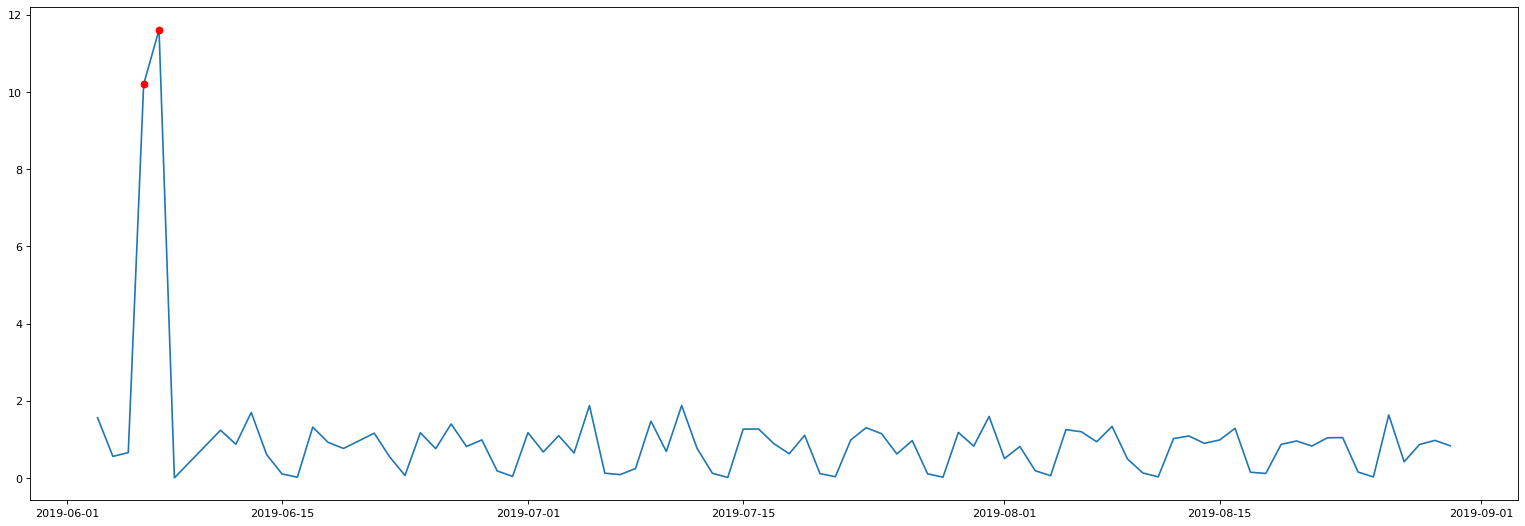

0000157599 Flower Stem Patterned Silk Scarf
No anomalies found for Flower Stem Patterned Silk Scarf
0000184215 Goat Wool Skirt
Calendar days [Timestamp('2019-08-01 00:00:00')]


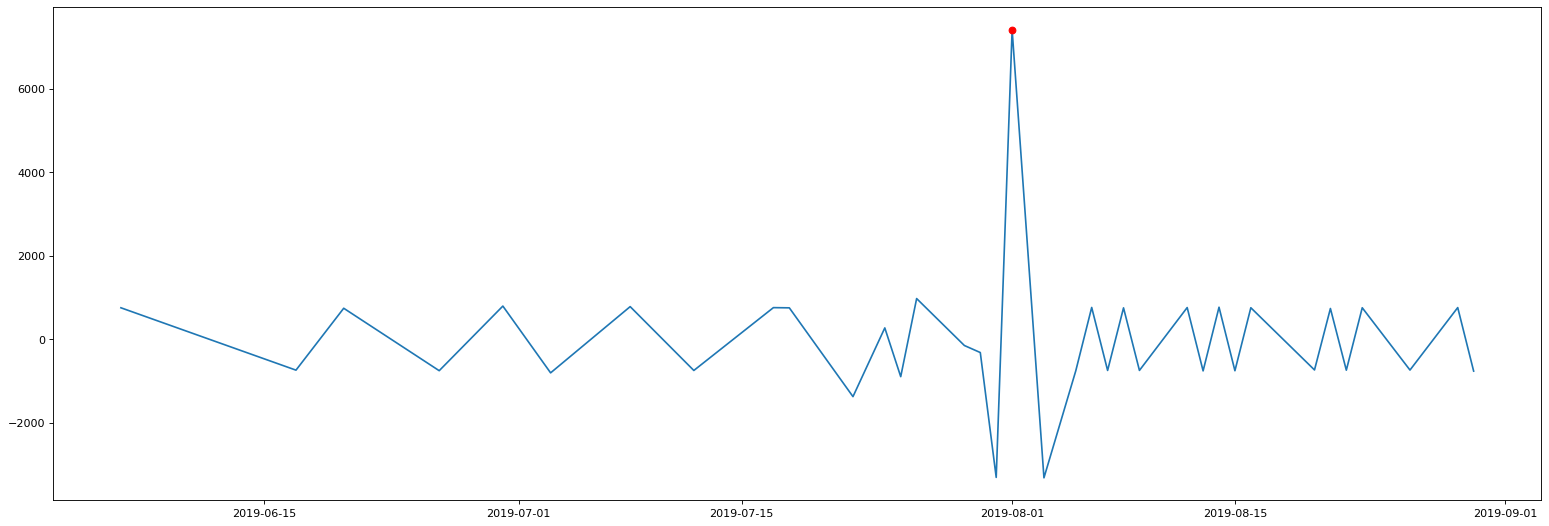

0000151810 Goldset Pearl Necklace
Calendar days [Timestamp('2019-06-07 00:00:00'), Timestamp('2019-06-13 00:00:00')]


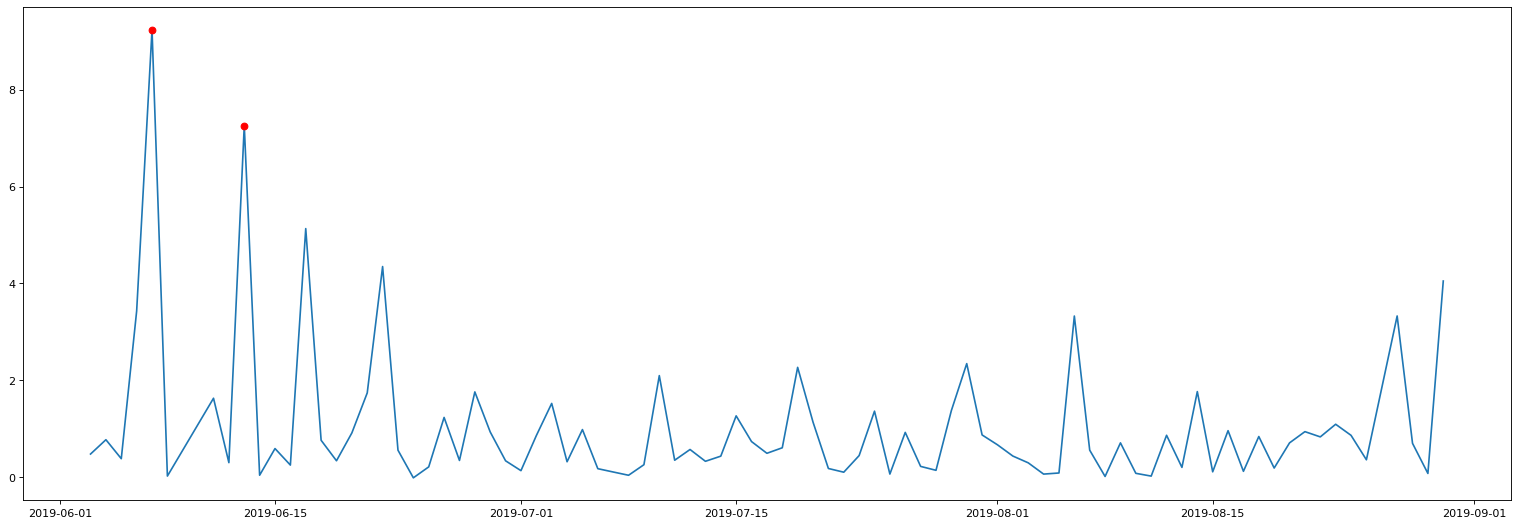

0000184264 Grenelle Printed Jeans
Calendar days [Timestamp('2019-08-27 00:00:00')]


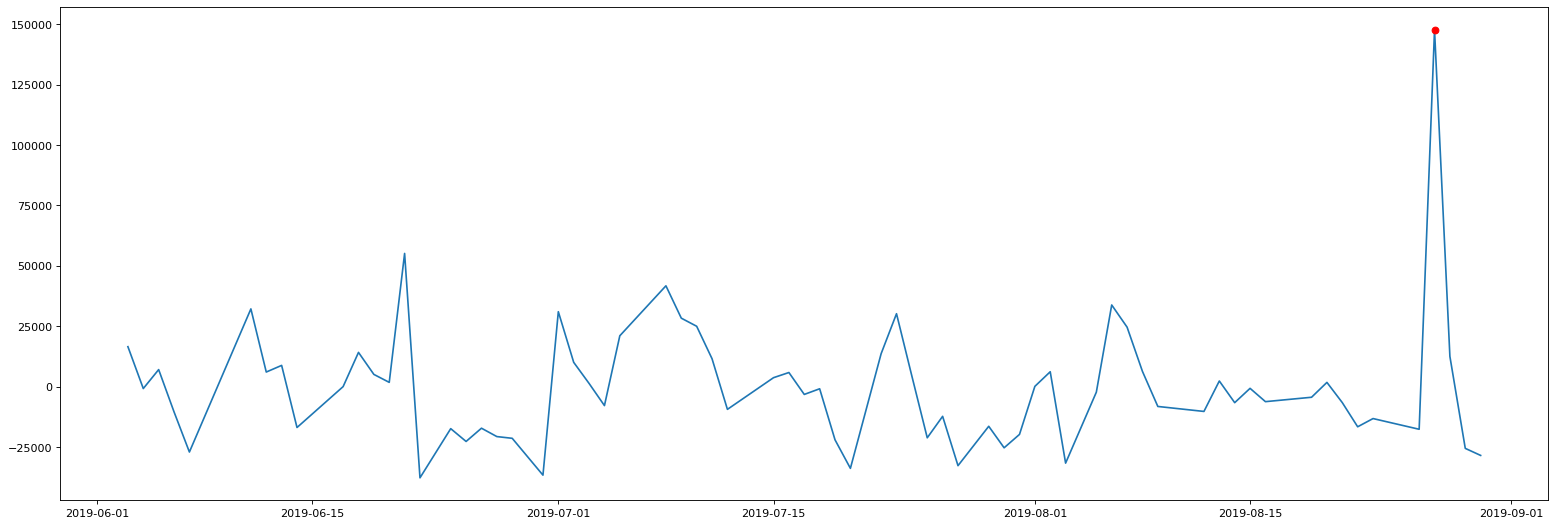

0000145403 Grooved Nickel Bracelet
No anomalies found for Grooved Nickel Bracelet
0000169272 Hair Clip
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


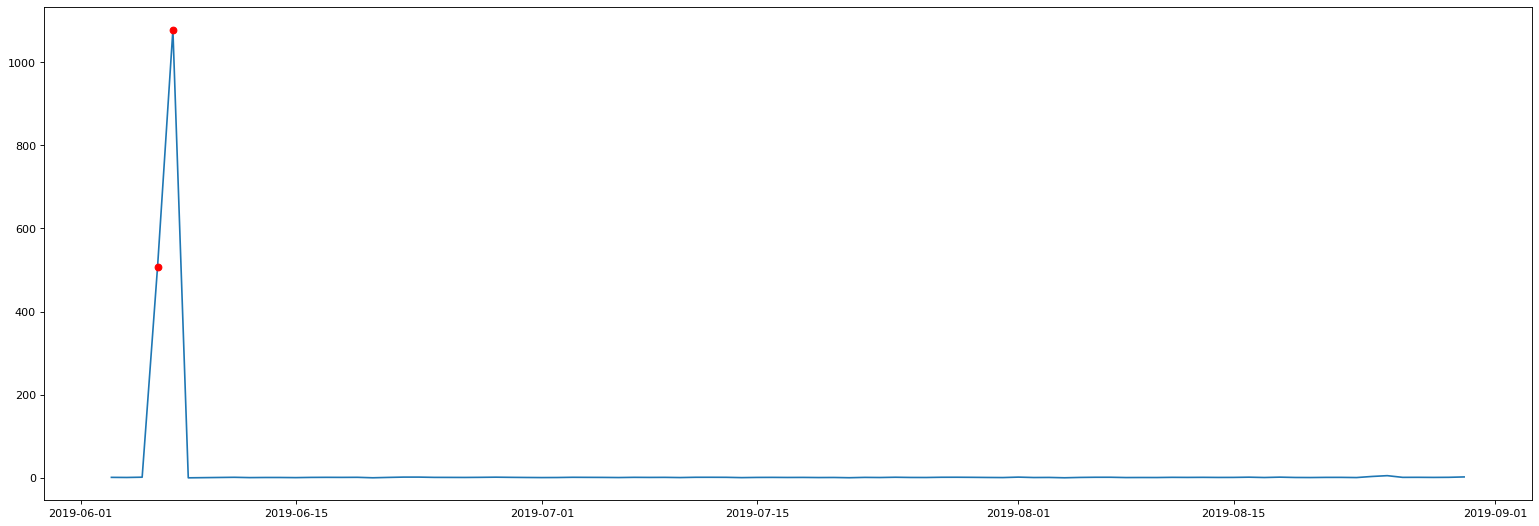

0000144940 Herringbone Cardigan
No anomalies found for Herringbone Cardigan
0000143269 Jacquard Scarf
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


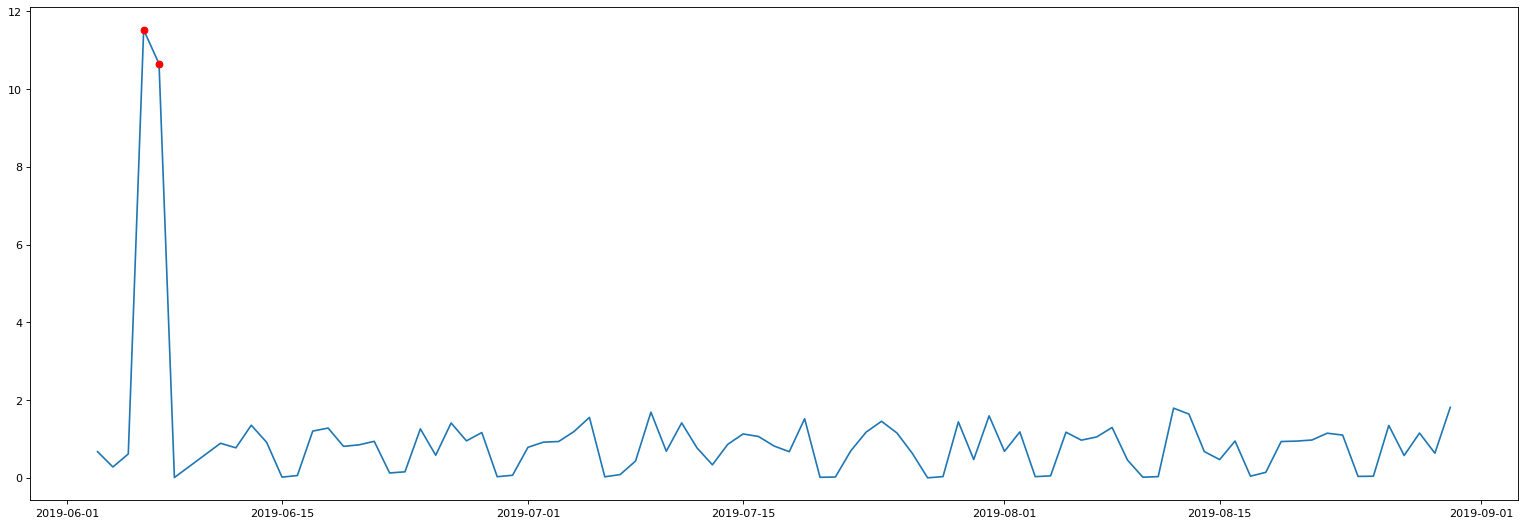

0000167119 Jacquard T-Shirt
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


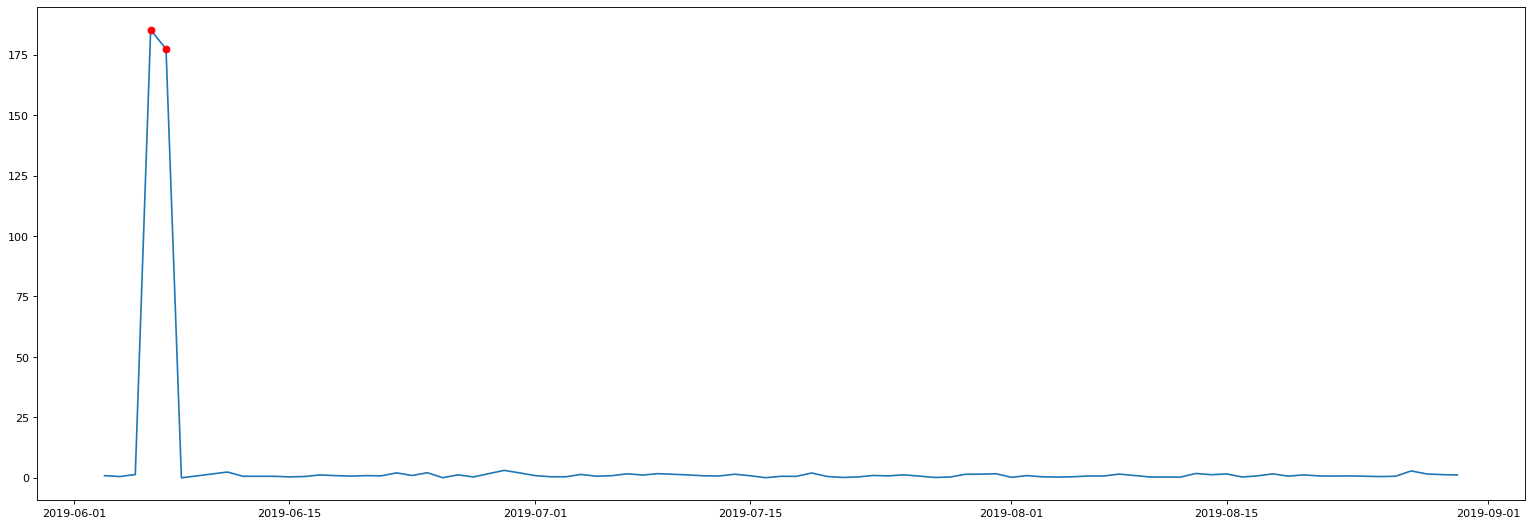

0000180368 Jacquard Turtleneck
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


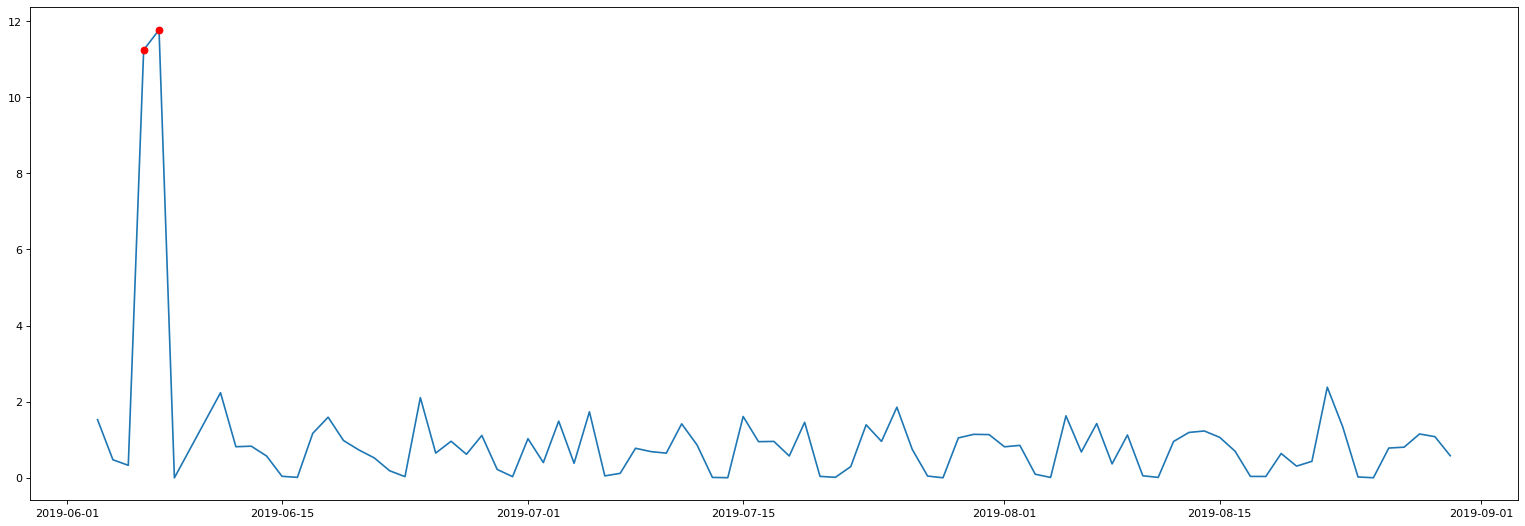

0000120114 Leather Belt
Calendar days [Timestamp('2019-06-06 00:00:00')]


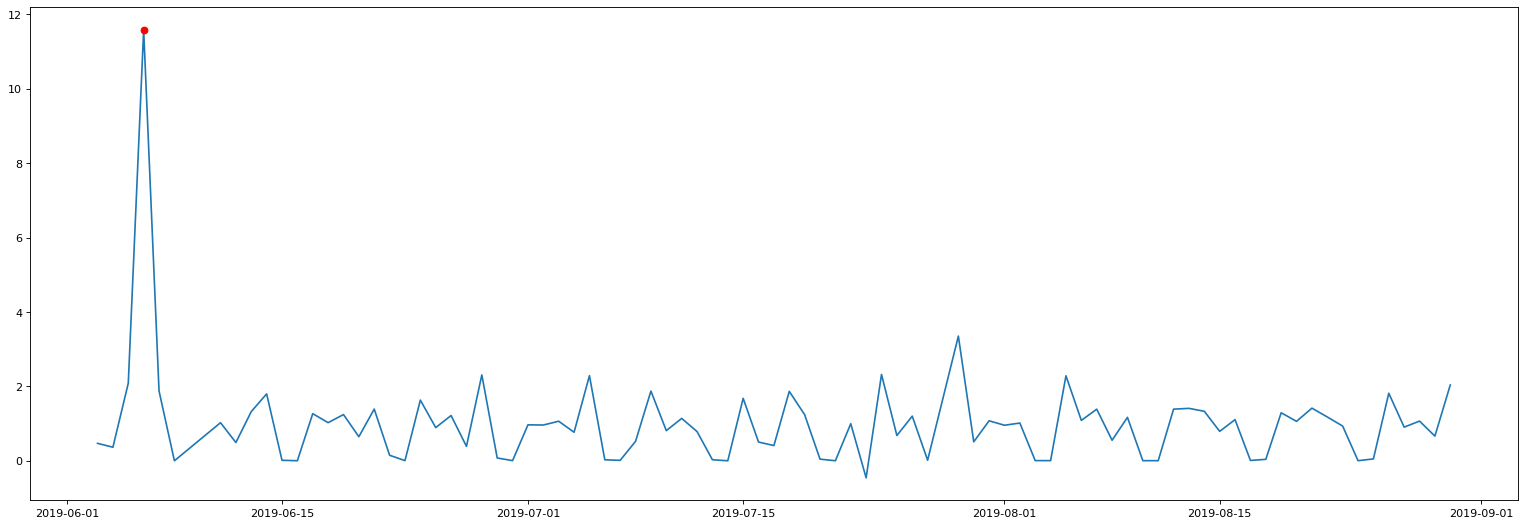

0000169227 Leather Trousers
Calendar days [Timestamp('2019-08-28 00:00:00')]


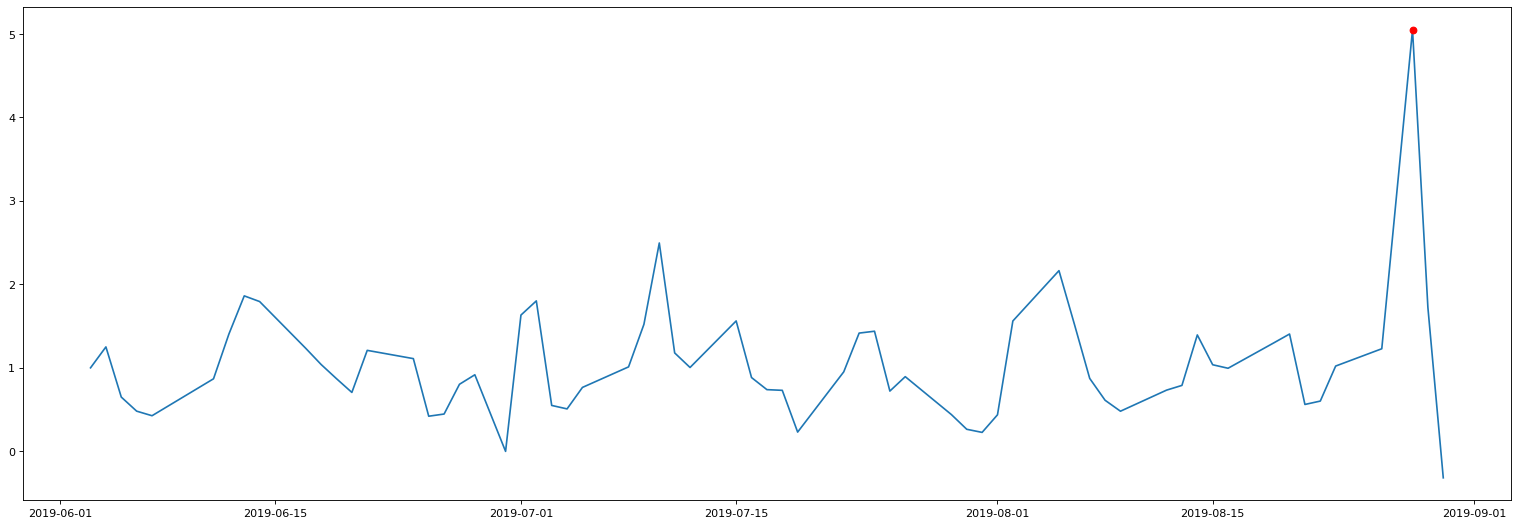

0000182919 Long Lace Skirt
Calendar days [Timestamp('2019-06-04 00:00:00'), Timestamp('2019-06-05 00:00:00'), Timestamp('2019-07-16 00:00:00')]


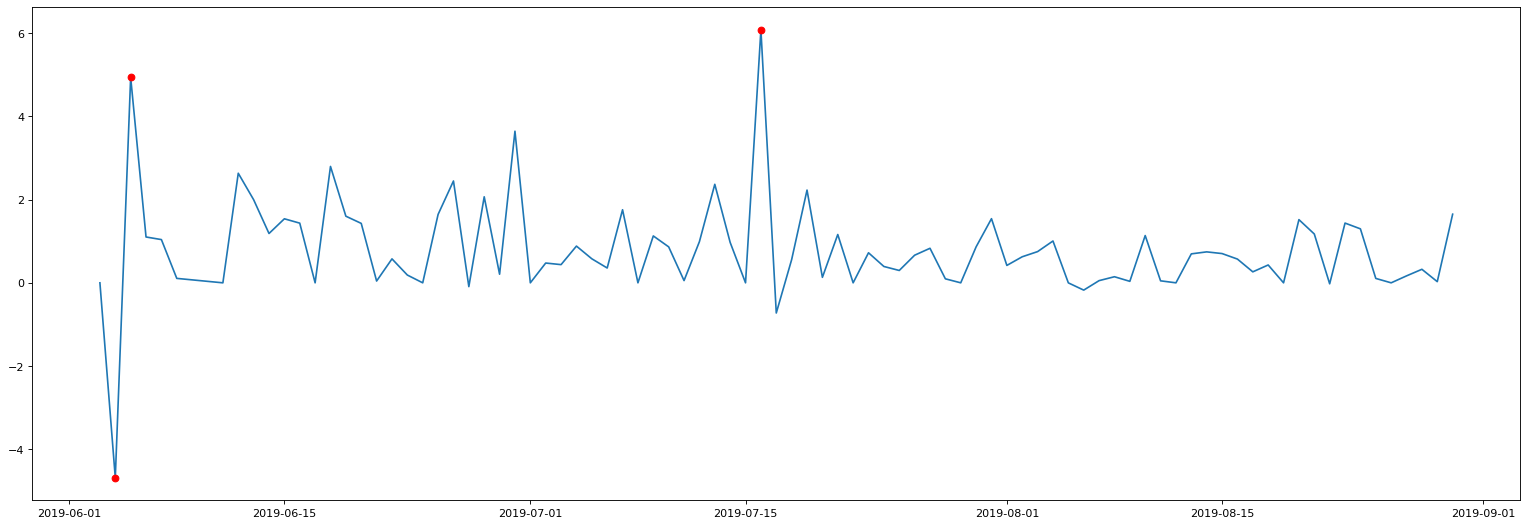

0000156171 Lycra Shorts
No anomalies found for Lycra Shorts
0000146751 Pearl and Diamond Necklace
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


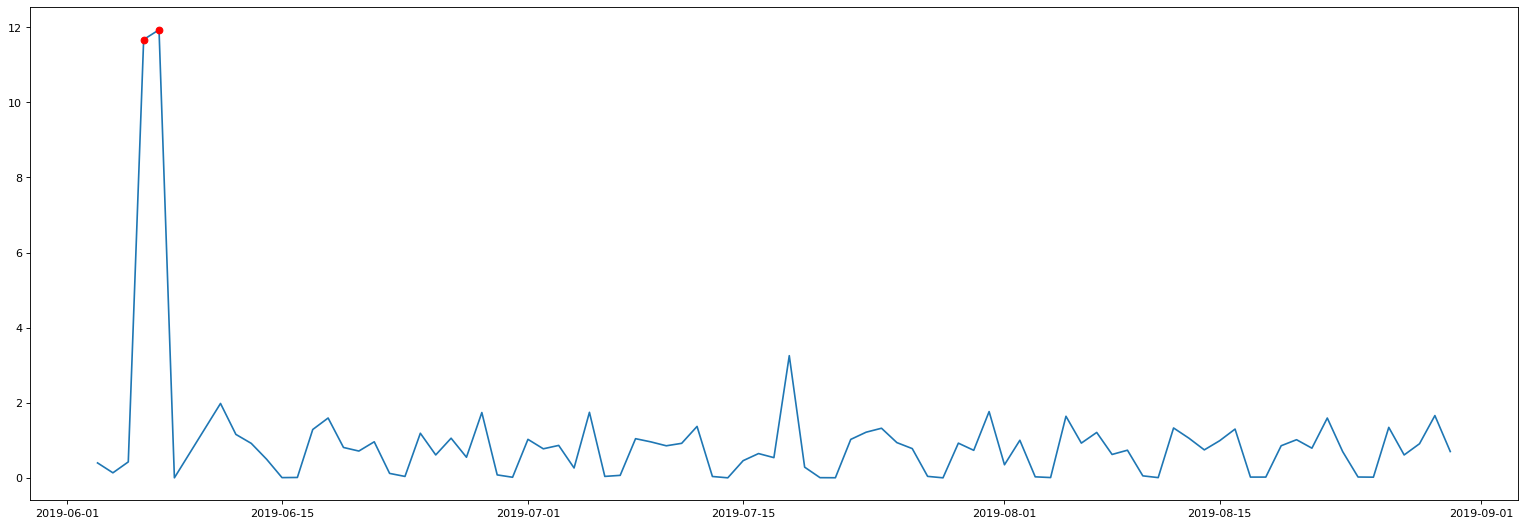

0000169301 Printed Lycra Trousers
Calendar days [Timestamp('2019-07-01 00:00:00')]


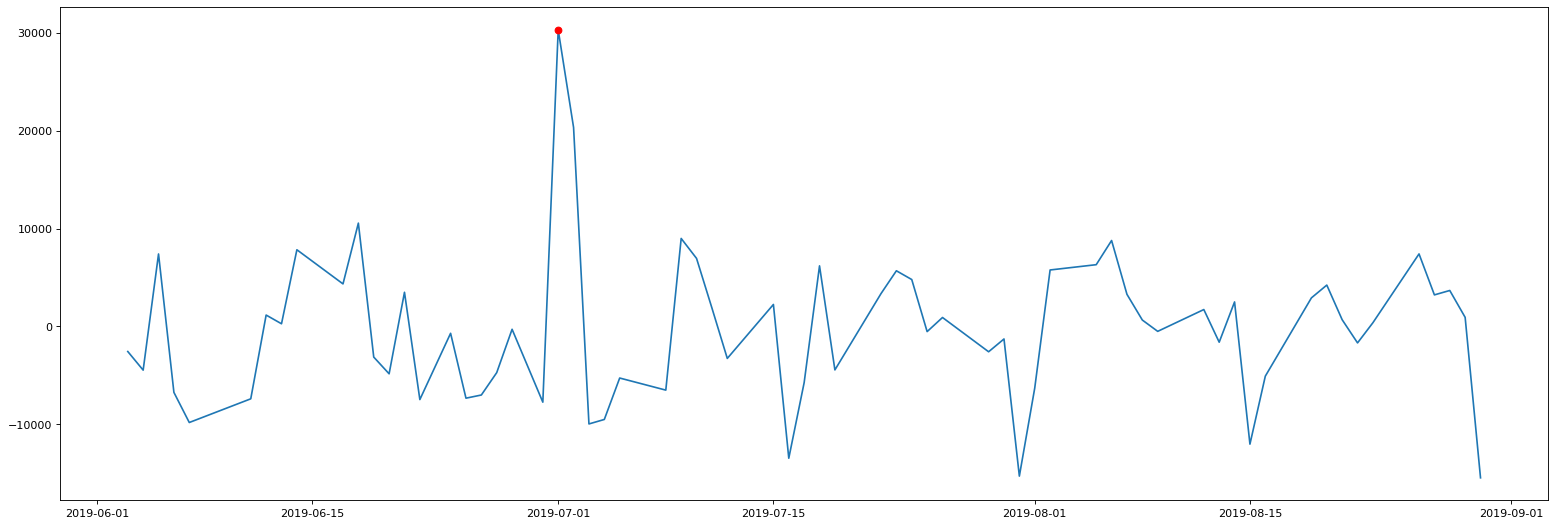

0000136786 Rigid Twisted Knot Bracelet
No anomalies found for Rigid Twisted Knot Bracelet
0000144102 Rounded Gold Brooch
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


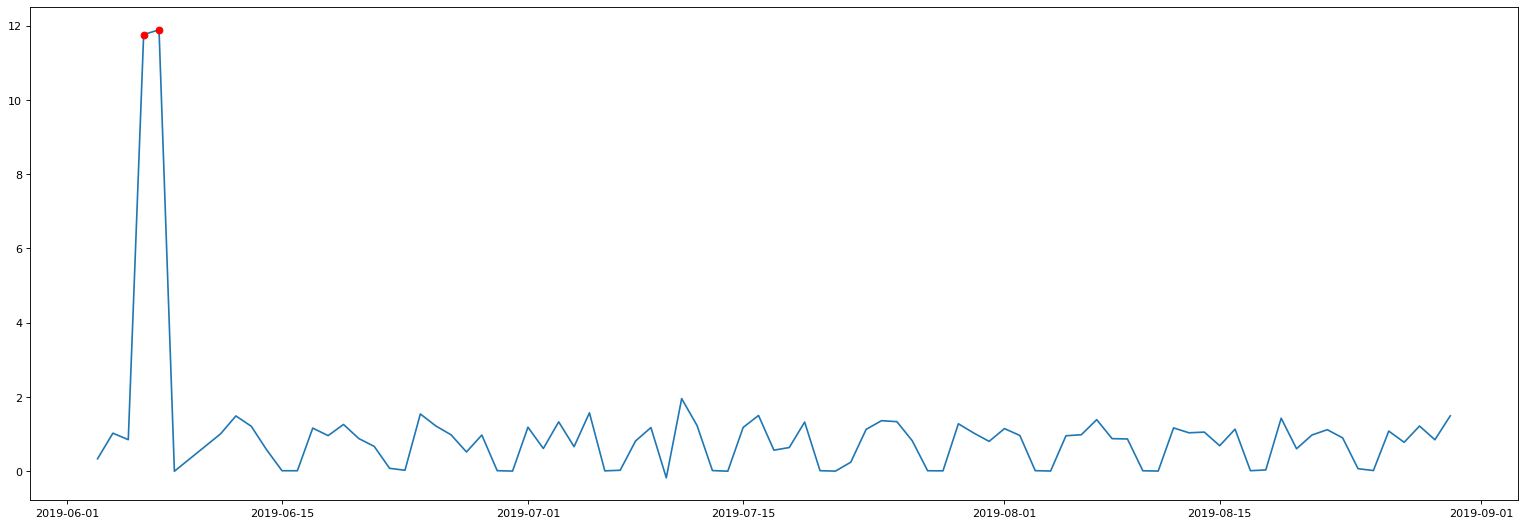

0000145404 Rounded Rectangle Brooch
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


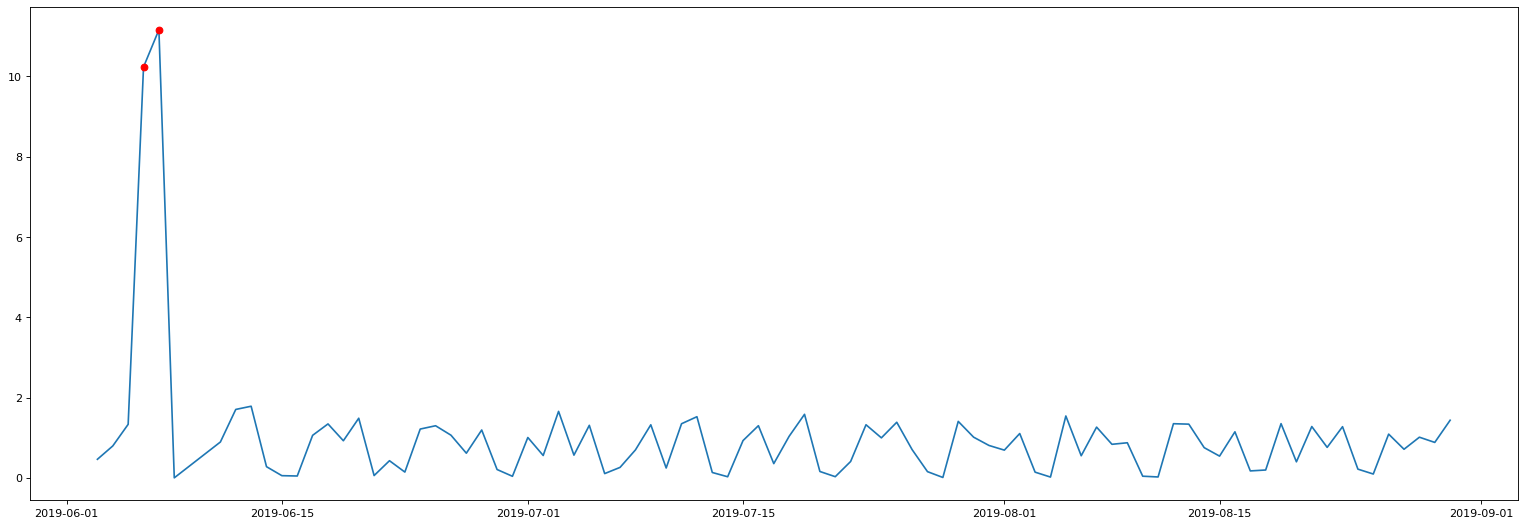

0000148032 Sandrine Stole
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


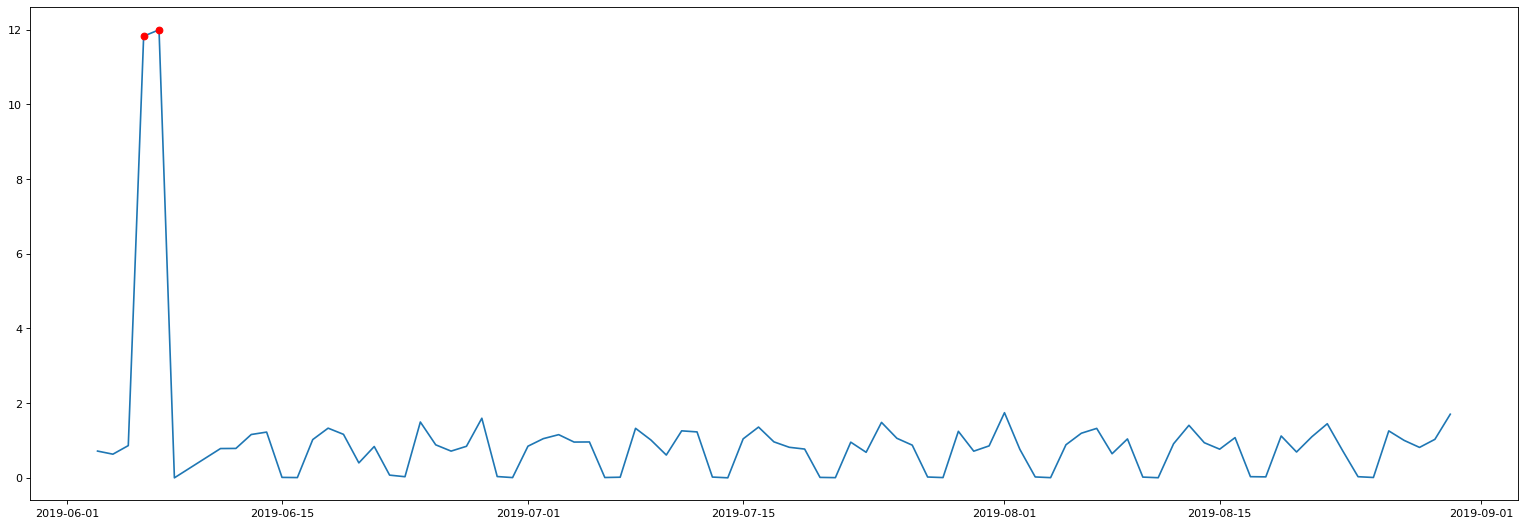

0000177376 Sequin Dress
No anomalies found for Sequin Dress
0000137638 Shell Headband
No anomalies found for Shell Headband
0000163019 Shetland Jacket
Calendar days [Timestamp('2019-06-21 00:00:00')]


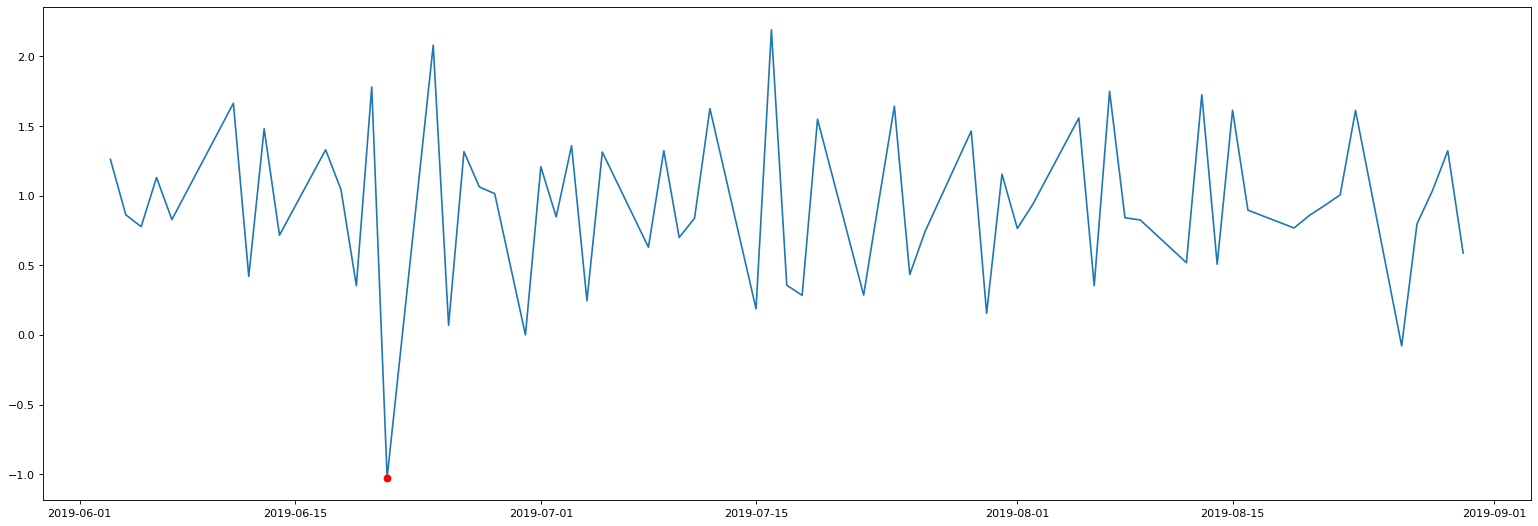

0000182313 Square Viscose Sample
Calendar days [Timestamp('2019-06-06 00:00:00'), Timestamp('2019-06-07 00:00:00')]


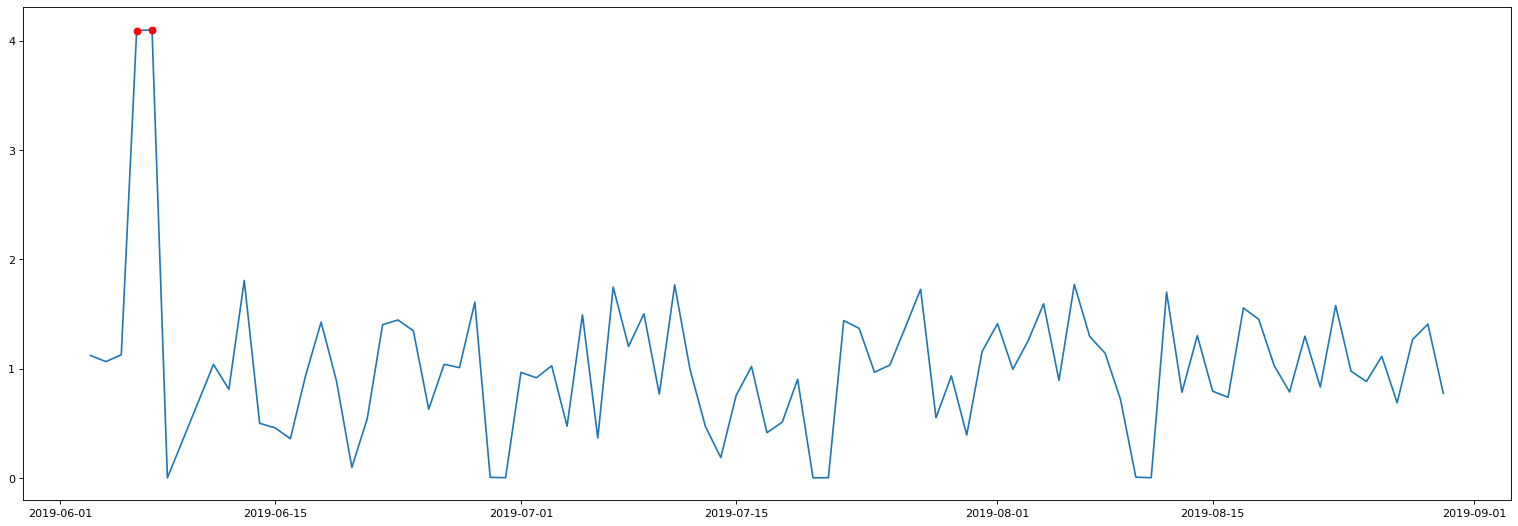

0000119427 Stole and Feather Boa Set
Calendar days [Timestamp('2019-07-17 00:00:00'), Timestamp('2019-08-21 00:00:00')]


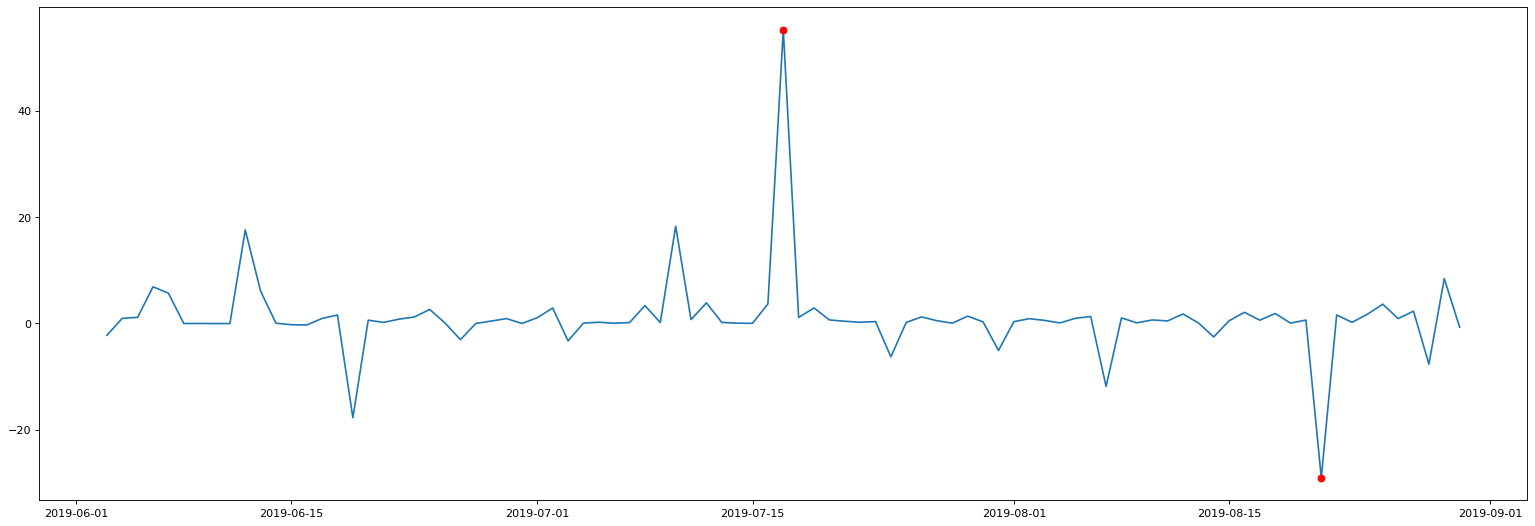

0000166579 Stretch Jeans
Calendar days [Timestamp('2019-08-28 00:00:00')]


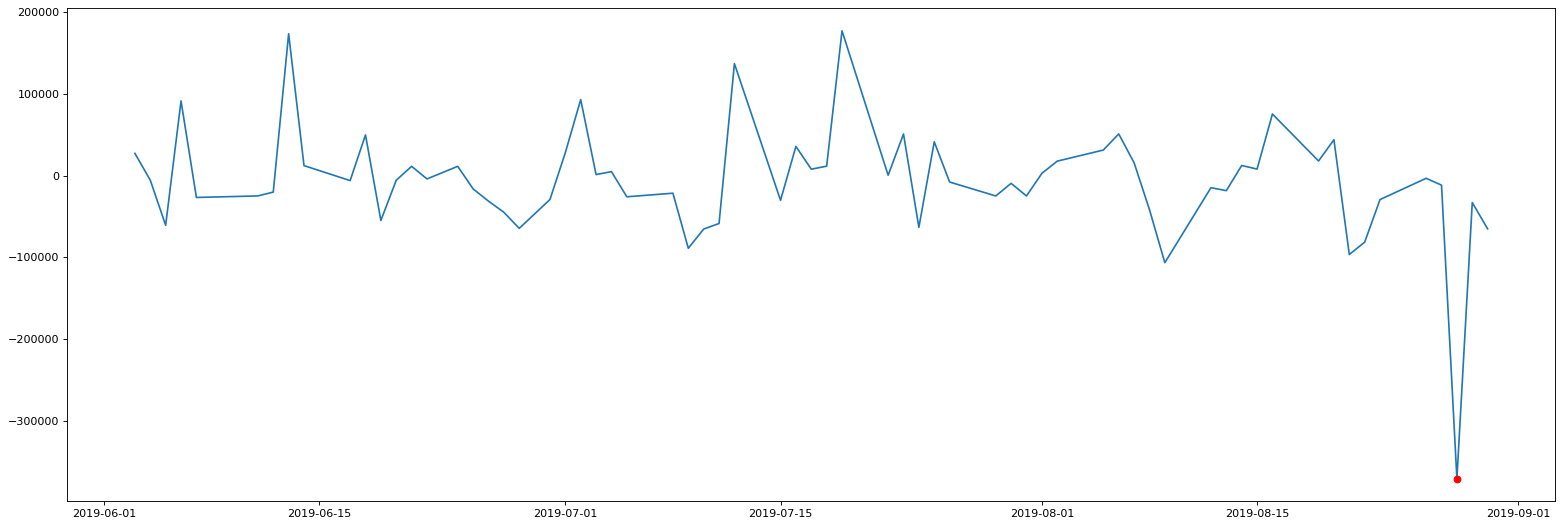

0000181756 Striped Turtleneck
Calendar days [Timestamp('2019-06-30 00:00:00')]


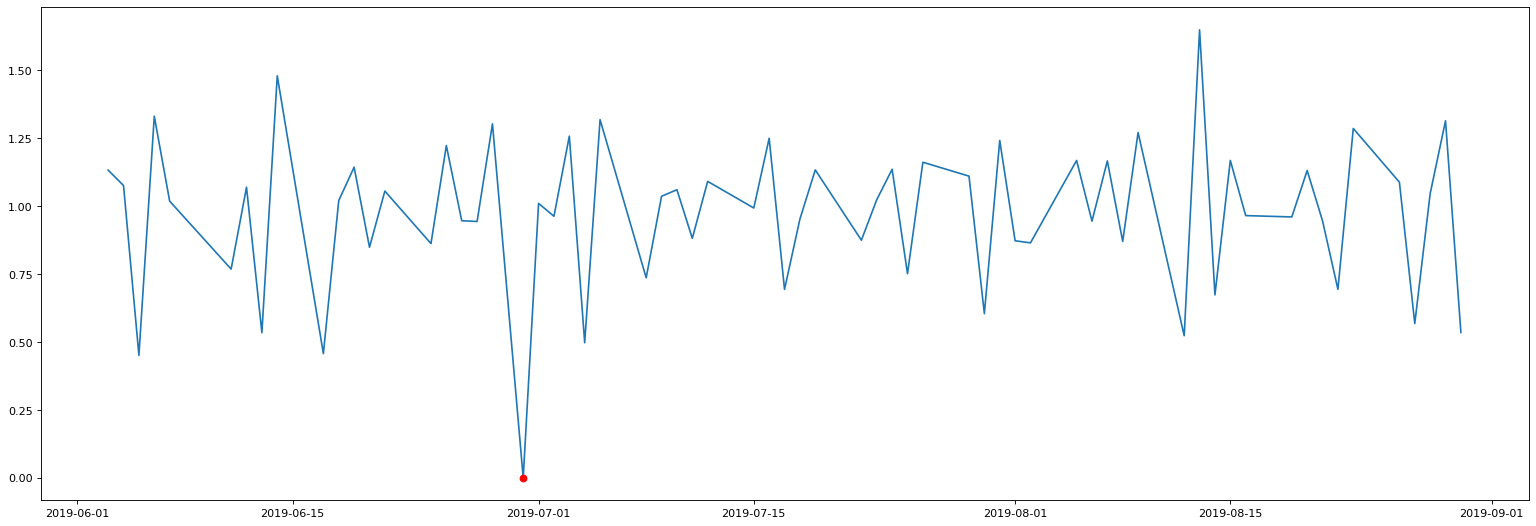

0000160243 Suede Cloth Belt
Calendar days [Timestamp('2019-06-06 00:00:00')]


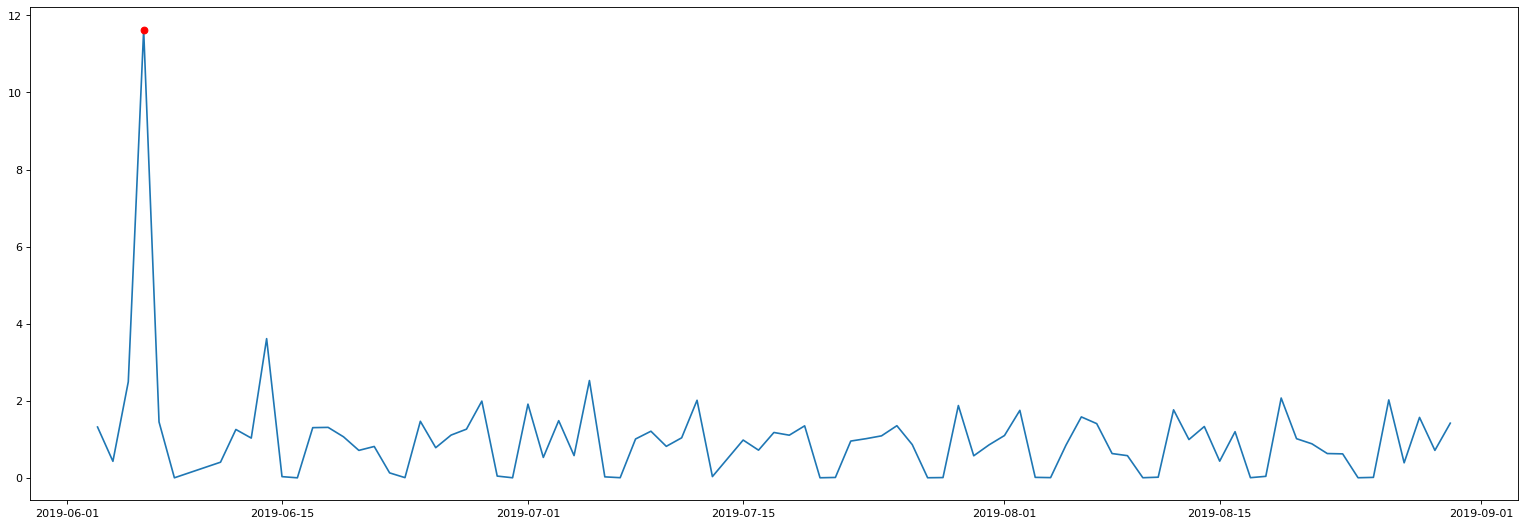

0000182330 Tapestry Turtleneck Sweater
No anomalies found for Tapestry Turtleneck Sweater
0000169432 Trenchcoat
No anomalies found for Trenchcoat
0000168499 Twill Dressing-gown
Calendar days [Timestamp('2019-07-26 00:00:00'), Timestamp('2019-08-01 00:00:00')]


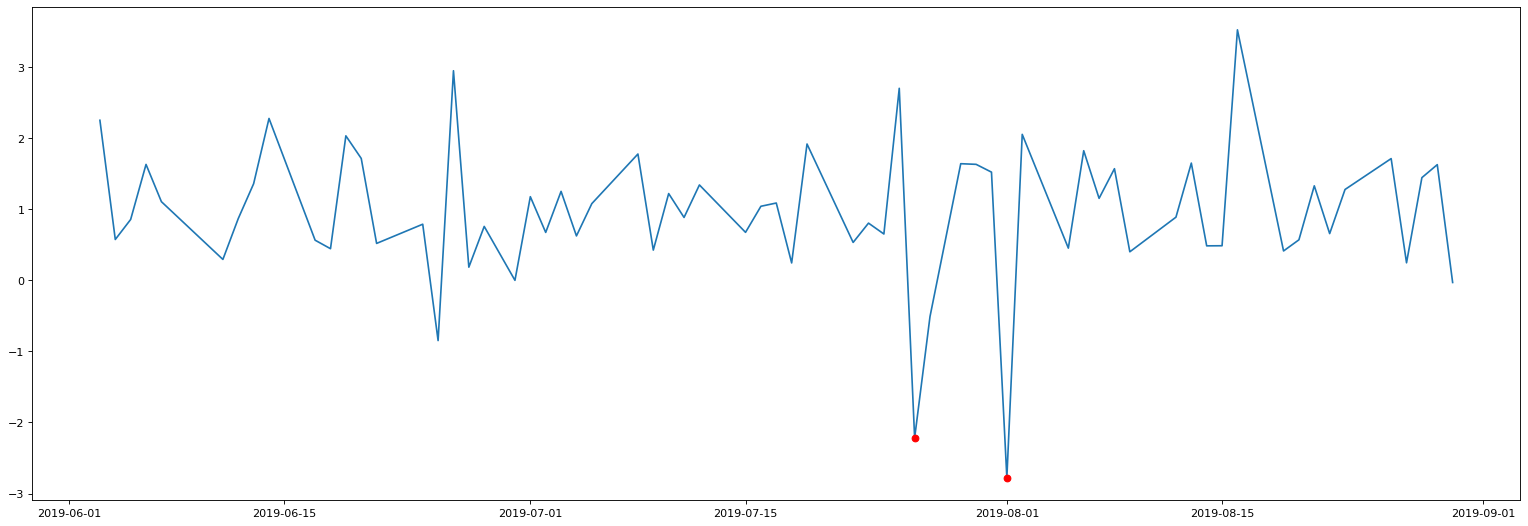

0000185125 Wool and Lycra Trousers
Calendar days [Timestamp('2019-06-03 00:00:00'), Timestamp('2019-06-04 00:00:00')]


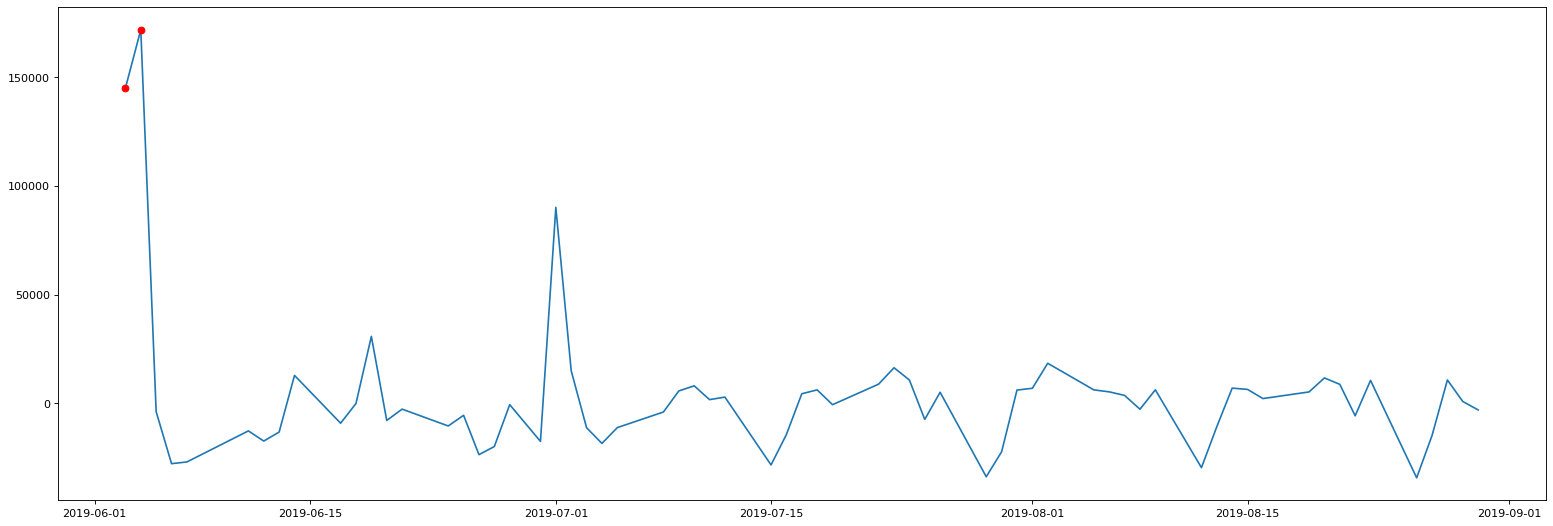

Total articles with anomalies: 37


In [10]:
df_anomalies_iqr = []
for zefart in zefarts.values.tolist():
    print(zefart[0], zefart[1])
    hdf_dfashion = hdf.filter('"ZEFART" = \''+zefart[0]+'\'')
    hdf_dfashion = hdf_dfashion.add_id(id_col='ID', ref_col='0CALDAY')

    # seasonal_decompose function is to decompose a time series into three components: trend, seasonality and random noise.
    # Once you remove the trend, seasonal and cyclical effects you can check for anomalies
    from hana_ml.algorithms.pal.tsa.seasonal_decompose import seasonal_decompose
    stat, decomposed = seasonal_decompose(data = hdf_dfashion,
                                        key = 'ID',
                                        endog = 'ZEFNS',
                                        extrapolation=True)

    # Methode 1
    # Variance Test is a method to identify the outliers of n number of numeric data {xi} where 0 < i < n+1, 
    # using the mean and the standard deviation of n number of numeric data.
    from hana_ml.algorithms.pal.preprocessing import variance_test
    test_res, _ = variance_test(data=decomposed,
                                key='ID',
                                data_col='RANDOM', # SEASONAL, TREND, RANDOM (white noise)
                                sigma_num=3)


    # Methode 2
    # Perform the inter-quartile range (IQR) test to find the outliers of the data. 
    # The inter-quartile range (IQR) is the difference between the third quartile (Q3) and the first quartile (Q1) of the data.
    '''
    from hana_ml.algorithms.pal.stats import iqr
    test_res, _ = iqr(data=decomposed, 
                      key='ID', 
                      col='RANDOM')  # SEASONAL, TREND, RANDOM (white noise)
    '''


    anomalies_iqr_id = conn.sql('SELECT ID FROM ({}) WHERE IS_OUT_OF_RANGE = 1'.format(test_res.select_statement))
    anomalies_iqr = conn.sql('SELECT * FROM ({}) WHERE ID IN ({})'.format(hdf_dfashion.select_statement,
                                                                    anomalies_iqr_id.select_statement))
    

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.pyplot import figure
    # If anomaly exists then plot a figure
    if anomalies_iqr.count() > 0:
        df_anomalies_iqr.append(zefart)
        df_dfashion = hdf_dfashion.collect()
        figure(figsize = (24, 8), dpi = 80)
        dc = decomposed.collect()
        # Base line 
        plt.plot(pd.to_datetime(df_dfashion['0CALDAY']), dc['RANDOM'])
        # Anomaly marker
        oidx = np.array(anomalies_iqr.collect()['ID']) - 1
        plt.plot(pd.to_datetime(df_dfashion['0CALDAY'])[oidx], dc.iloc[oidx, 3], 'ro')
        print('Calendar days', pd.to_datetime(df_dfashion['0CALDAY'])[oidx].to_list())
        plt.show()
    else:
        print('No anomalies found for '+zefart[1])

# Next step would be analysing anomalies in more detail for relevant articles
print('Total articles with anomalies: '+str(len(df_anomalies_iqr)))

Anhand der Anomaly Detection je Artikel ergibt sich ein deutlich klareres Bild als noch zuvor über alle Artikel. Durch die Reihung der einzelnen Visualisierung lässt sich sehr gut erkennen, dass als Muster der 06.06.2019 (Donnerstag) und 07.06.2019 (Freitag) angezeigt werden.

Das korrekte Vorgehen wäre nun eine Überprüfung der Artikel für das relevante Datum hinsichtlich des Umsatzes. Dies ist nicht Bestandteil der aktuellen Analyse, da wir generell bewerten wollten, ob das Datenprofil nach vorheriger Überprüfung generell für die Überprüfung auf Einflussfaktoren geeignet ist. 

Nachdem das Gesamtbild aller Artikel relativ ernüchternd war, stellt sich bei der Analyse nach Artikel ein wesentlich besseres Bild der Daten dar.